
Like many of you, whenever the Montreal Canadiens hockey team have a match, it can happen that my compadres and I might find ourselves in a sports bar. 
 
Guzzling down pints and stuffing my face face with burgers among my fellow hockey fans, I sometimes wonder of the relationship between our beloved sports team’s performance on ice and how it affects our performance with the pints and burgers (i.e how much revenue sport bars make). 
 
Have you thought about that too? Of course you have.  Because you are of the numerically inclined! Which is why the meanderings of your life have brought you here to my humble page. 

So let's see if how the Montreal Canadiens are doing determine how well sports bars are doing.

About the data:
 
La cage aux sport, owned by Sportscene is one of the biggest sport bars in Quebec and only operates in Quebec. I decided to collect their quarterly revenues from their financial statements which I found on http://www.sedar.com
 
As for the Hockey data, I got it from http://ourhistory.canadiens.com/stats/search#/dashboard/players/
 
I will first take a look at the sport bar data alone and see what I can make of it. Then I will bring in the hockey data and see if it adds anything.

So let’s take a look! 



At first I'm just going to load up the data and wrangle it a little bit in order to to get started. You can look at it or hold your nose.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing

#plt.style.use("seaborn")
plt.style.use('fivethirtyeight')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
from myscripts import *

data=pd.read_csv("sportscenedata/sportscene.csv",index_col="date",parse_dates=True)

data.columns=["quarter","half","year"]
data.sort_index(inplace=True)

data=data.groupby(data.index).first()

data=data.iloc[:,[0,2]]
data.iloc[:,0]=data.iloc[:,0].str.replace(",","")

data=data.apply(pd.to_numeric)
data=data.fillna(0)
data["revenue"]=data.iloc[:,0]+data.iloc[:,1]

yearly_data=data.revenue[data.index.month==8]
quarters_data=data.quarter[data.index.month!=8]

if quarters_data.shape[0]%3!=0:
    quarters_data=quarters_data.iloc[:-(quarters_data.shape[0]%3)] #not done with current year,


grouped_up=np.split(quarters_data, quarters_data.shape[0]/3)

totals=[]
for tmp in grouped_up:
    totals.append(tmp.sum())
    
#Every 4rth bar revenue data point shows the revenue for the entire year, so to find how that quarter did, need to difference with the rest

data.revenue[data.index.month==8]=data.revenue[data.index.month==8].values-totals

#resampling to MONTHLY so as to get the end of month
data=data.revenue.resample("M").sum()
data.dropna(inplace=True)

all_dates_inplay=data.index.date


There! Now let's see what sportscene revenue looks like on a quarterly basis. 

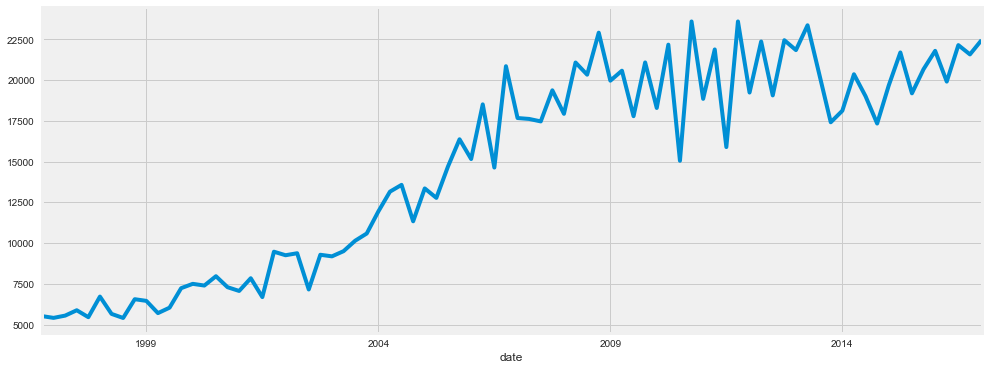

In [2]:
data.plot()

Pretty choppy eh? We'll get a clearer look as to what's behind this real soon.

# Creating stats for bar data


In [3]:
window=8
bar_data_stats=create_stats(pd.DataFrame(data),window,rolling_mean_shifted=True)
bar_data=pd.concat([data,bar_data_stats],axis=1)
bar_data.dropna(inplace=True)


What does my custom function do? It create creates statistics based on the inputed data. 

The window parameter is used for the rolling average calculated within. A window of 8 means it will calculated mean will be of the 8 past data points. 8 quarters means two years. 

To give you a quick idea, here's what they're called.

In [4]:
print(bar_data.columns)

Index(['revenue', 'revenueRollingMean', 'revenueRollingStd', 'revenueRelAvg',
       'revenueRelAvgDifferenced', 'revenueRelAvgRollingMean',
       'revenueRollingStandardization', 'revenueRollingNormalization'],
      dtype='object')


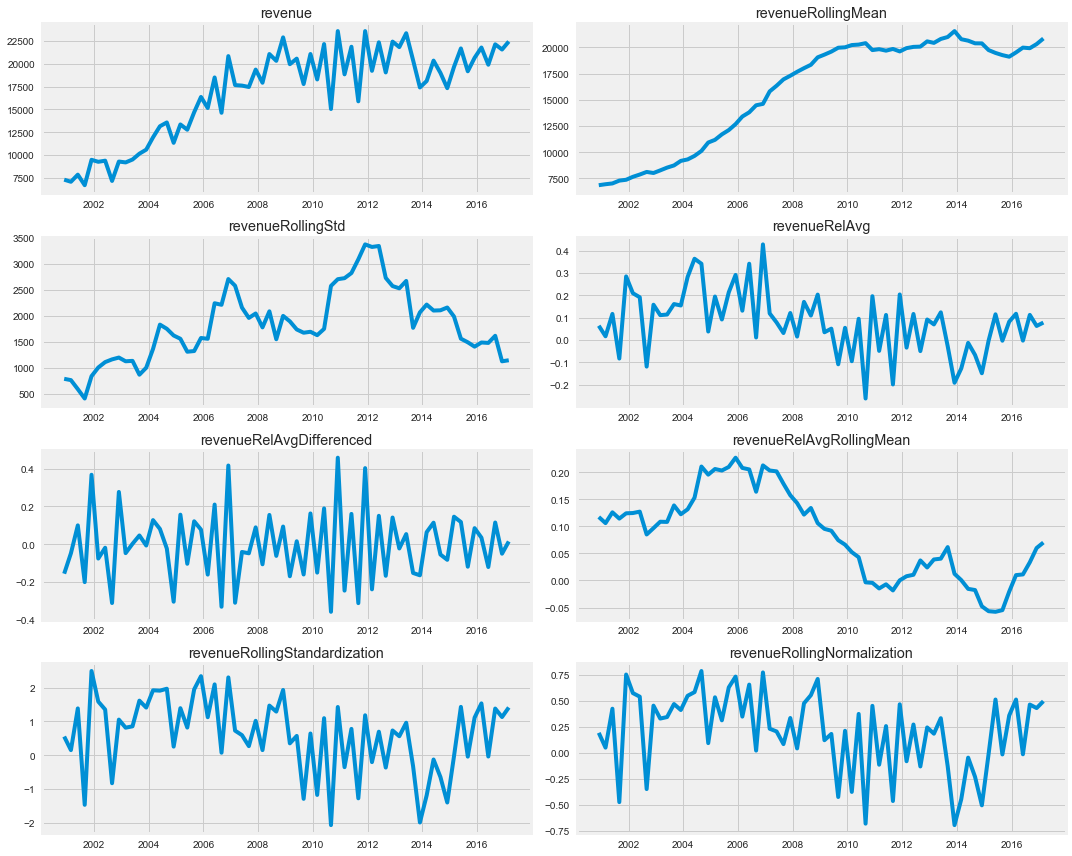

In [5]:

nber_of_graphs=bar_data.columns.shape[0]
graphs_per_row=2
nber_of_rows= np.ceil(nber_of_graphs/graphs_per_row)

nber_of_rows_number=nber_of_rows*100
graphs_per_row_number=graphs_per_row*10

i=1
base_number=nber_of_rows_number+graphs_per_row_number

plt.rcParams['figure.figsize'] = (15, 3*nber_of_rows)
#['revenueDifferencedRollingStandardization','revenueRollingNormalization','revenueDifferencedRollingNormalization']:
    
for each_column in bar_data.columns:    

    plt.subplot(base_number+i) 
    plt.plot(bar_data[each_column])
    plt.title(each_column)
    i+=1
    plt.tight_layout()




Above you can see what the extra columns look like. They're just variations of the original revenue input. 


In [6]:
plt.rcParams['figure.figsize'] = (15, 9)

chosen_bar_data=bar_data.revenueRelAvg


Let's take a closer look at the revenueRelAvg one

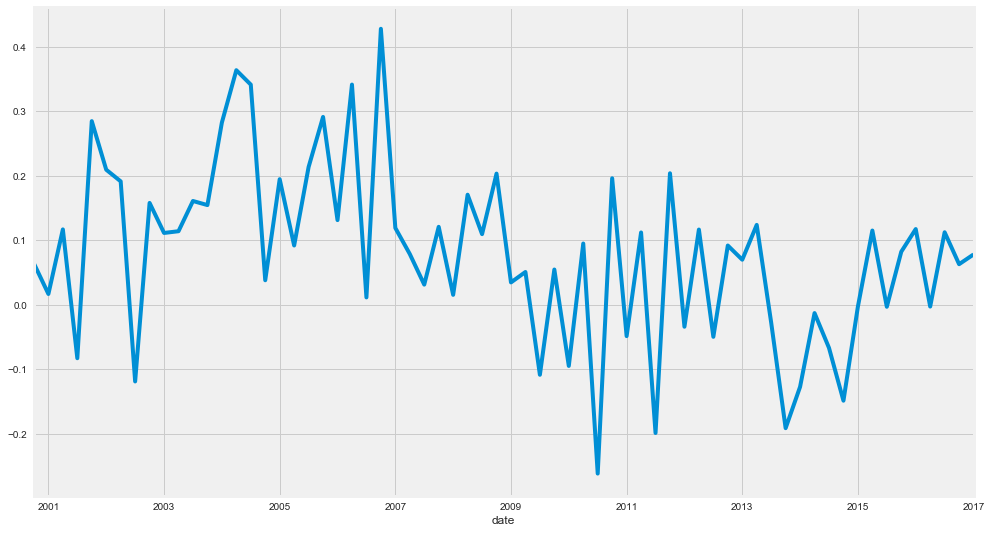

In [7]:
chosen_bar_data.plot()

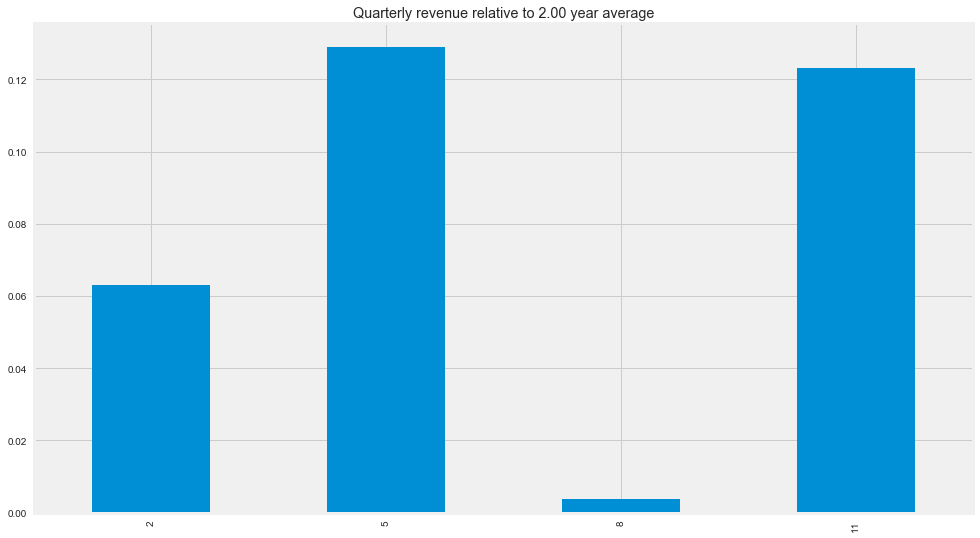

In [8]:
chosen_bar_data.groupby(chosen_bar_data.index.month).mean().plot(kind="bar",title="Quarterly revenue relative to %.2f year average"%(window/4));

So this is a little better. Here we can clearly see that typically, it's third quarter is its weakest with it's quarterly revenue typically being below its 2 year quarterly revenue. 

What I also see is that there seems to be a pattern. I could easily divide this into half years and the "first" part would always be lower than the second one. 


Now this data across time is what's called a timeseries. The key thing to remember is that you can't just run a regression on it straight off the bat. Regressions along with many other statistical tests assume the data points are independent of each other and that the probability distribution of the data and its variance remain the same throughout (stationarity). 

In this case they aren't independent as they all depend on time. Therefore special models like ARIMA and SARIMAX are needed.

As for stationarity, if we were to look at the quarterly revenue, it seems to increase gradually while never reverting to a mean. In theory it could go on to infinity, which makes this definitely non-stationary. Now I could difference the revenue, but I'll keep going with with the quarterly revenue relative to its 2 year mean that I've got. 

By making it relative to its average, I've restrained where the value could go. You'll notice it'll always revert back to 0. 
Take a look below.


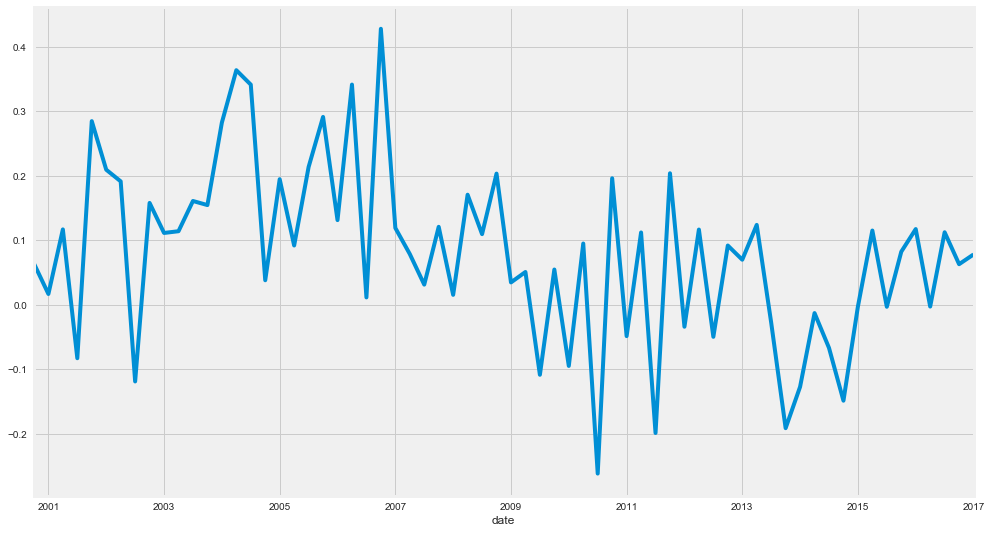

In [9]:
#log them to help with the stationarity
#stationary_data=np.log1p(bar_data[[0]]-bar_data[[0]].shift())

#stationary_data=chosen_bar_data-chosen_bar_data.shift()
stationary_data=chosen_bar_data

stationary_data.dropna(inplace=True)
stationary_data.plot()




Let's test it for stationarity to make sure. The best method for detecting stationarity is with what's called the  the Dickey-Fuller test.

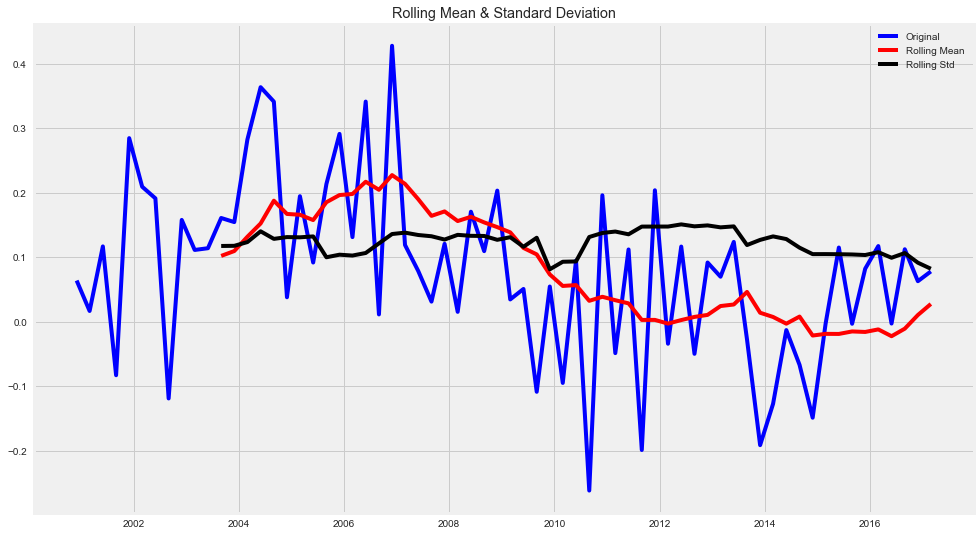

Results of Dickey-Fuller Test:
Test Statistic                -6.983509e+00
p-value                        8.078281e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


In [10]:
test_stationarity(stationary_data)


Using the Dickey-Fuller test we can see that our test statistic is even lower than that of the 1% critical value, meaning there's less than a 1% chance that we would've gotten these results and that the series was not stationary. 


Moving on, let's look to see if our data has any autocorrelation, which is to say, do previous results help predict future results? There are quick ways to tell if there might be some.

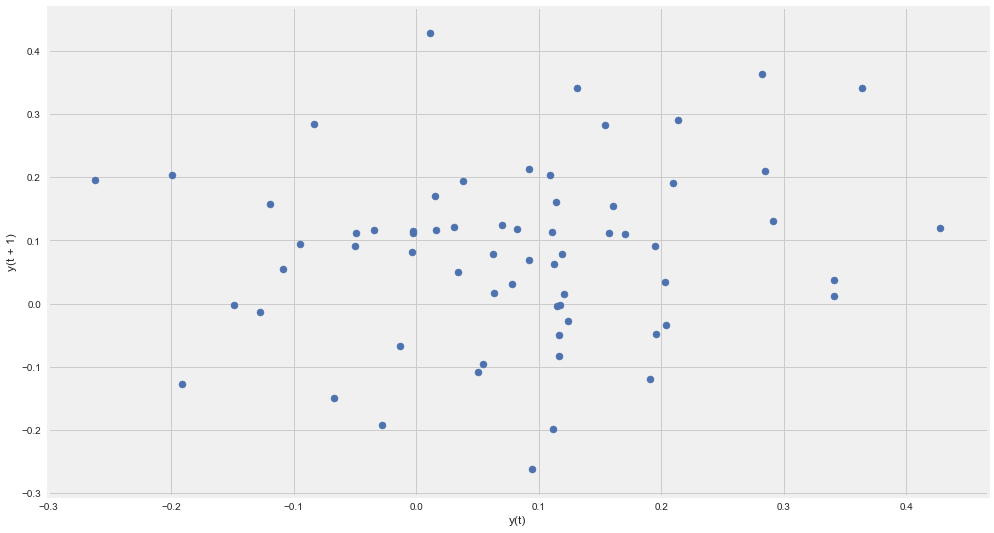

In [11]:
lag_plot(pd.DataFrame(stationary_data))

This chart plots every data point along with its next data point as the coordinate for each dot. Had there been some strong autocorrelation, some clear pattern might've emerged. In this case, it looks random. Now there still might be some autocorrelation, but it wouldn't be that strong. Either that or the autocorrelation might not be with its neighbouring values.


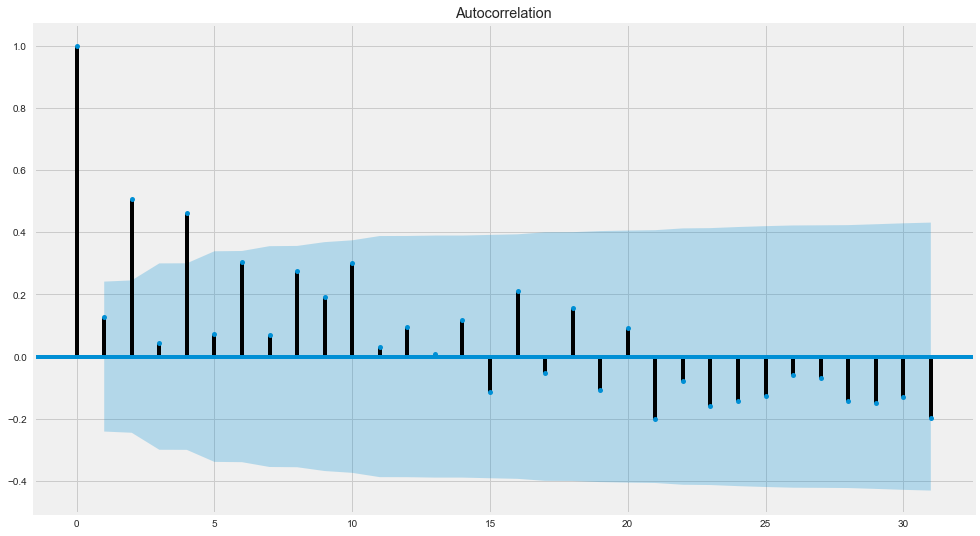

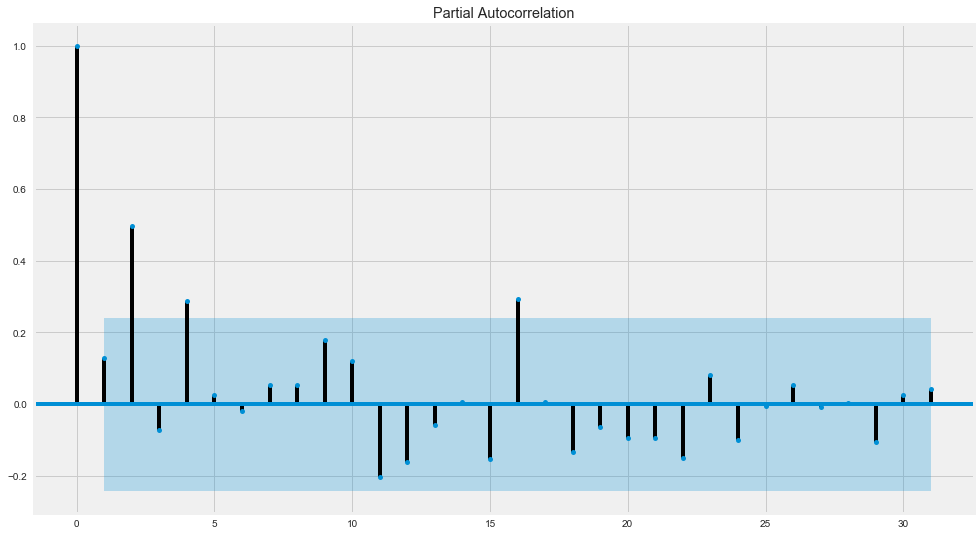

In [12]:
time_series_info_on_y(stationary_data)

The Autocorrelation Function (ACF) basically incorporates all the lags un until the selected value. So ACF(4) looks at how all the lags up until lag 4 correlate with your prediction

Partial Autocorrelation Function (PACF) only looks at that one particular lag. Notice here that it looks like there is some autocorrelation for the second lag.

Anything outside of the shaded area usually implies some statistically significant relationship. Anything within the shaded area is considered noise. So the lag of 1 and the lag of 3 in the PACF for example don't seem significant.

So here we see that lag 2 and 4 seems significant. This will be important later.


# Game plan

I will first try to predict the next quarterly revenue purely based on its past revenue. Then I will try to incorporate hockey data and see if that improves things.

I will be using what's called a SARIMAX model and then I will try a machine learning technique called the ElasticNet regression.

 
# Going the SARIMAX route below. No exogenous variables, just pure lags

Before tackling SARIMAX, what is an ARIMA model? ARIMA stands for AutoRegressive Integrated Moving Average.
It allows you to take in raw timeseries apply transformations to make it stationary, analyze and then come up with a prediction. 

The variables it takes in are ARIMA(p,d,q). 
p stands for how many lagged values do you want to take into account when making your prediction for the next value.
This speaks directly to the AutoRegressive component of the model. 
For example a lag of 1 (AR(1)) means you are using today's temperature to predict tomorrow's temperature. 
AR(2) means tomorrow's tempurature is correlated with yesterday and today's temperature.

d is for differencing. Which explains the Integrated part of the arIma model. The number d just means how many times you differenced your data. So a difference of 1 means Y2-Y1, Y3-Y2. So basically instead of having the temperature of everyday, you have the difference in temperature compared to the previous day. If d=2, then you'd be dealing with the difference of the difference in temperatures.

q is for moving average (MA). The key thing to keep in mind here is that we are looking at the ERRORS for "q" lags and trying to see if they correlate with our prediction. What are those errors you might ask?

When you do an AR(2) process, we try to predict using 2 lags. Naturally when we try to fit these with lots of data, you'll never get an exact fit. You'll get errors for each lags.It's the noise, the residual. Those errors in our predictions is what we'll be using for MA(2).
If the noise is completely random then it's uninformative. But in some cases there will still be some structure or information left in them, which why we might have to take them into account in order to better predict.

And finally we have SARIMAX. 

It's simply an ARIMA model but with seasonality in mind. If you run a business you typically have high and low seasons. And so if I want to predict my sales for the summer, the best predictor for it might simply be last year's summer, but not so much all the time/lags in between. The model has extra parameters P,D,Q which do the same things as p,d,q but compared across their matching seasons.


# Define the p, d and q parameters

Now there's a whole lot of litterature on how to choose your parameters. 
View this link here for a taste.
https://people.duke.edu/~rnau/411sdif.htm
The thing is it can take a lot of time to do it manually. So what I've done is simply used gridsearch that will look at all possible combinations and try them all. The best model survives.




Below I split my data into train and test sets. I decided not to use those from sklearn preprocessing because from what I've read it randomizes the datapoints before assigning what's for training and what's for testing. This would be great were our datapoints independent of each other. In our case with timeseries, they are not.

In [13]:
#make sure to also check window
train_pct=0.8
split_data=train_test(train_pct,y=bar_data)

y_train=split_data["y_train"]
y_test=split_data["y_test"]
mid_data_index=split_data["mid_data_index"]
y_all=bar_data
train_test_index=split_data["train_test_index"]

The following code was based on this terrific guide right here https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [14]:
p=q = range(0,4)

d=range(0,2)

Generating all different combinations of p, q and q triplets

In [15]:
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets

In [16]:
seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 2)
SARIMAX: (0, 0, 1) x (0, 0, 2, 2)
SARIMAX: (0, 0, 2) x (0, 0, 3, 2)
SARIMAX: (0, 0, 2) x (0, 1, 0, 2)


You can set do_sarimax=True if you want to run the grid search, but it could take a while. By default I set it to the answer the gridsearch would have provided.

In [17]:

do_sarimax=False #in case I don't want to run this thing again.

if do_sarimax==True:
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    best_score, best_cfg = float("inf"), None
    for each_measure_unit in ['revenue','revenueRollingMean','revenueRelAvg','revenueRollingStandardization','revenueRollingNormalization']:

        for param in pdq:
            for param_seasonal in seasonal_pdq:

                try:
                    mod = sm.tsa.statespace.SARIMAX(y_train[each_measure_unit],
                                                    order=param,
                                                    exog=None,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)

                    results = mod.fit()


                    if results.aic< best_score:
                        best_score=results.aic
                        best_cfg=[param, param_seasonal]
                        best_measure_unit=each_measure_unit
                        print('ARIMA{}x{} - AIC:{} with data {}'.format(param, param_seasonal, results.aic,each_measure_unit))
                except:
                    continue

    print("BEST FIT")            
    print('ARIMA{}x{} - AIC:{} with data {}'.format(best_cfg[0], best_cfg[1], best_score,best_measure_unit))
else:
    print("skipping Sarimax")
    #ARIMA(2, 0, 1)x(0, 0, 0, 4)4 - AIC:-90.93117578195475 with data revenueRelAvg
    best_measure_unit="revenueRelAvg"
    best_cfg=[(0, 0, 0), (1, 0, 1, 2)]


skipping Sarimax


We're judging the model with the Akaike Information Criterion (AIC score)

I won't be discussing this at length but the key thing to remember about AIC is that it balances complexity and accuracy. Adding more parameters or lags will can always make the model more precise. But does that extra parameter REALLY add enough to warrant adding that parameter in the first place? Is adding more complexity to the model worth that extra bit of accuracy? The AIC score will tell us. 
The better the model the lower the AIC score. 

Finally it seem that model is best at predicting the relative average rolling mean (which is how the quarterly revenue compares to its two year average) which is very informative still.


# NOW TO ANALYZE THE BEST ONE

In [18]:

mod = sm.tsa.statespace.SARIMAX(y_all[best_measure_unit],
                                order=best_cfg[0],#order=(1, 0, 1),
                                seasonal_order=best_cfg[1],#seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.aic)
print(results.summary().tables[1])


-85.3379760988
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2        0.8989      0.084     10.749      0.000       0.735       1.063
ma.S.L2       -0.5224      0.165     -3.158      0.002      -0.847      -0.198
sigma2         0.0136      0.003      5.181      0.000       0.008       0.019


So the best model to survive in this case used 1 seasonal lag and 1 seasonal moving average. I've selected seasonality of 2, meaning I am splitting my year into 2 and seeing if there are any similarities between the half-years.

The p values are also at either at 0 or close to it which is a very strong sign for statistical significance. The p value basically tells you the odds of you having the results you have and the coefficient for you variable being 0 (which means your variable having no effect).

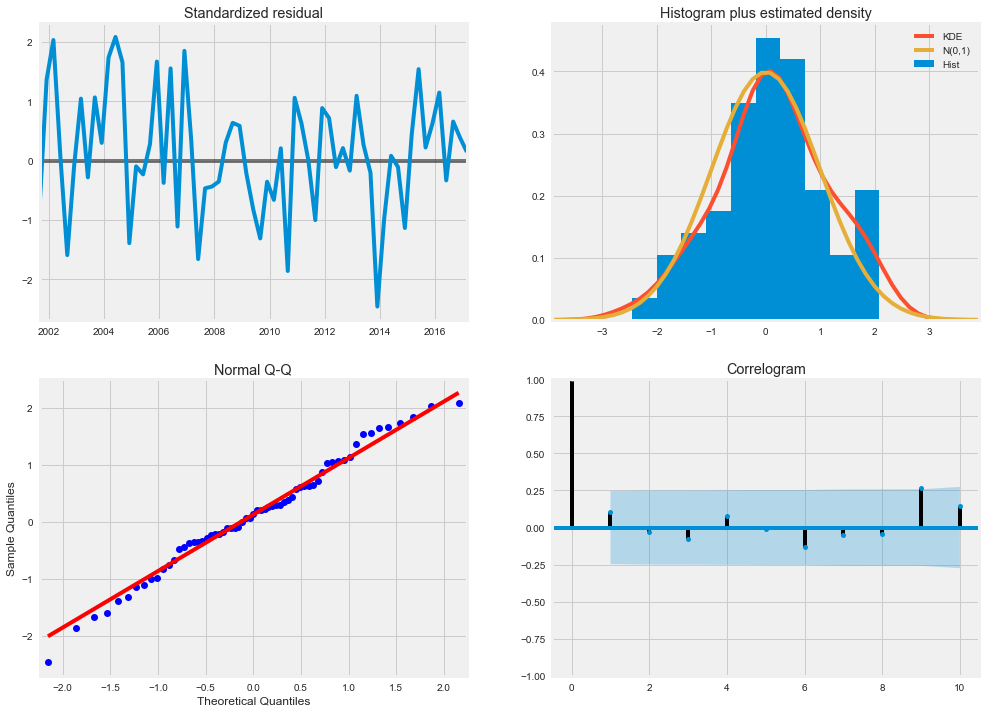

In [19]:
#Statsmodel the library used here has great charts that are automatically produced for you whenever you run your Sarimax models.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

The top left, top right and bottom left charts basically plot the errors. We want to make sure that the errors are look somewhat normal (i.e follows a gaussian distribution). From the look of things, it's not a perfect Gaussian, looking at the top right you can see that too many of the results are positive. 
Still it's not too far off. Let's go with it. 

# FORECASTING
Let's see what our predictions would look like.

In [20]:

pred = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=False)
#The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.
pred_ci = pred.conf_int()

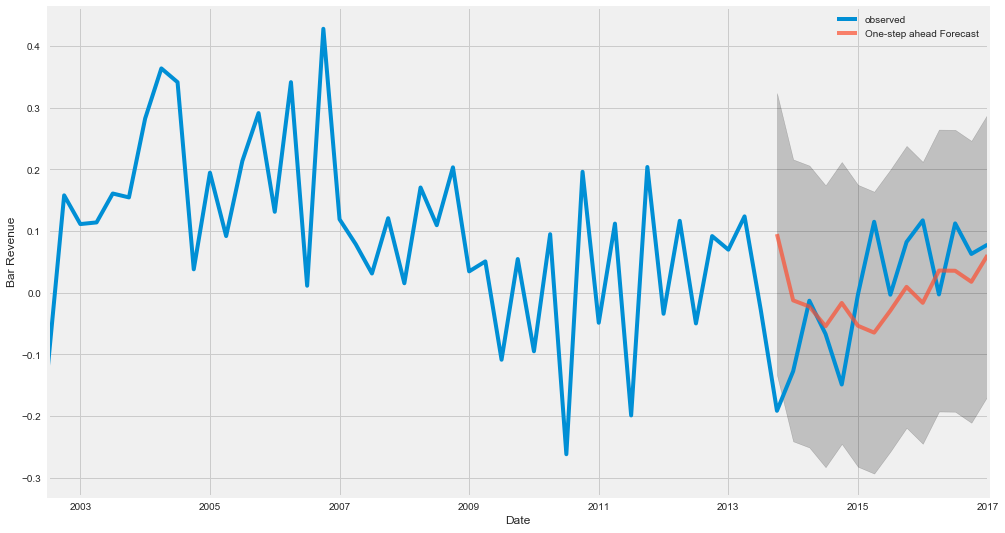

In [21]:

ax = y_all[best_measure_unit][mid_data_index:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bar Revenue')
plt.legend()

plt.show()



# Computing the mean square error


In [22]:
y_forecasted = pred.predicted_mean 
y_truth = y_test[best_measure_unit]

forecast_mse = ((y_forecasted - y_truth) ** 2).mean()
baseline_mse = ((y_truth-y_truth.shift()) ** 2).mean()
no_guess_mse=((y_truth) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))




My forecast MSE : 0.01296872110200406, 
simply using previous value MSE : 0.0088441962983534, 
straight line MSE :0.00972582779639378


This doesn't look too bad, but the main thing to keep in mind here is that our model is constantly being updated with the real observations that took place. 

Often times the TRUE test of a good model is how much it can predict when it's fed its own predictions.



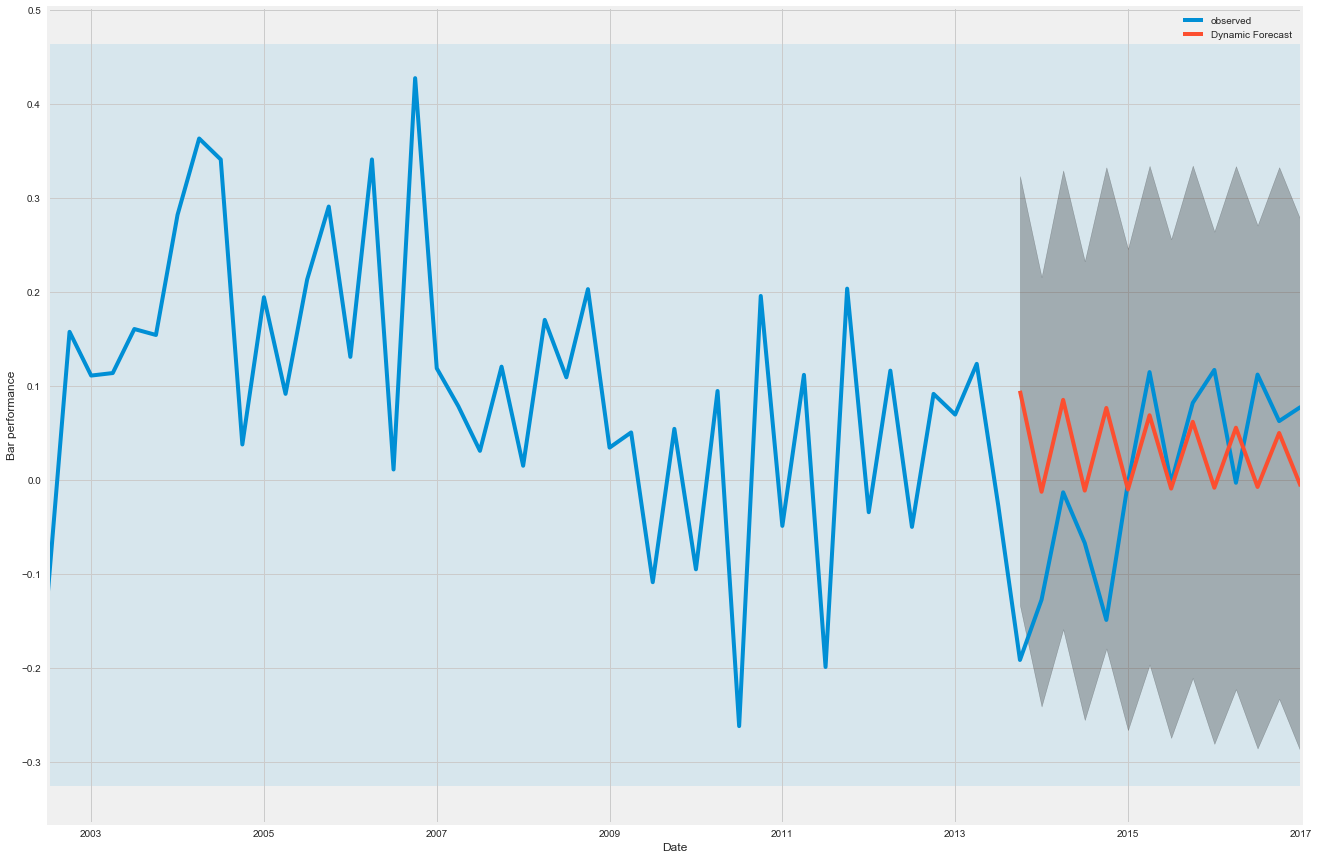

In [23]:
pred_dynamic = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = chosen_bar_data[mid_data_index:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(mid_data_index), chosen_bar_data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bar performance')

plt.legend()
plt.show()

In [24]:
y_forecasted = pred_dynamic.predicted_mean 
y_truth = y_test[best_measure_unit]

forecast_mse = ((y_forecasted - y_truth) ** 2).mean()
baseline_mse = ((y_truth-y_truth.shift()) ** 2).mean()
no_guess_mse=((y_truth) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))



The Mean Squared Error of our forecasts is 0.014465305383755804


Not very good eh? Basically we can get some idea of where we'll be for the NEXT period. But anything farther than that and the model has no idea. 

Look how big the confidence intervals are. As time goes on, the confidence interval increases since there are more places the real observations could be as it has more time to move.


This configuration is entirely dependent on the previous lag. Which when predicted on its own prediction makes a for a pretty stable answer...


Now so far we've merely tried to predict the companies business using it's own past sales. Let's see how well it fares when we implement some hockey data.

# Hockey data

Now let's take a look at the hockey data. 

In [25]:
hockey_data=pd.read_csv('mtl_hockey_granular.csv',usecols=["DATE","AWAY","HOME"],index_col="DATE",parse_dates=True)
hockey_data.head()

,AWAY,HOME
DATE,,
1910-01-19,MTL 4,REN 9
1910-01-22,MTL 4,OTT 6
1910-01-26,OTT 8,MTL 4
1910-02-02,MTL 3,SHA 8
1910-07-02,HAI 5,MTL 9


Just looking at hockey games, what are a few of its characteristics that could determine how much business sports bars get? 
Is the team playing at home or away? 
(If at home, they might just go to the stadium instead of the bar)
Is the game on a Thursday-Saturday night? Or is it on a monday? 
Have the MTL Canadiens been losing for a while? Winning for a while? What about the number of goals? 
Is the variance of goals a big draw?

Let's transform the table into a more useful format.

In [26]:
hockey_data.columns=['Away','Home']
hockey_data["MtlGoals"]=hockey_data.Home
hockey_data["OppGoals"]=hockey_data.Home

#separating the goals from the name
away_goals=hockey_data.Away.str.extract('(\d+)').astype(int)
home_goals=hockey_data.Home.str.extract('(\d+)').astype(int)

#this version will cause the 'A value is trying to be set on a copy of a slice from a DataFrame.' problem
#hockey_data[hockey_data.Away.str.contains("MTL")]."MtlGoals"=away_goals[hockey_data.Away.str.contains("MTL")].values

mtl_home=hockey_data.Home.str.contains("MTL")
mtl_away=~hockey_data.Home.str.contains("MTL")

hockey_data.loc[mtl_away,"MtlGoals"]=away_goals[mtl_away].values
hockey_data.loc[mtl_home,"MtlGoals"]=home_goals[mtl_home].values

hockey_data.loc[mtl_home,"OppGoals"]=away_goals[mtl_home].values
hockey_data.loc[mtl_away,"OppGoals"]=home_goals[mtl_away].values

hockey_data.Away=hockey_data.Away.str.replace('\d+', '')
hockey_data.Home=hockey_data.Home.str.replace('\d+', '')

hockey_data["Opp"]=hockey_data.Away
hockey_data.loc[mtl_away,"Opp"]=hockey_data.Home[mtl_away].values
hockey_data.loc[mtl_home,"Opp"]=hockey_data.Away[mtl_home].values

#I need these to be numbers because later on I will be summing them up

hockey_data.loc[mtl_away,"Away"]=1
hockey_data.loc[mtl_away,"Home"]=0

hockey_data.loc[mtl_home,"Away"]=0
hockey_data.loc[mtl_home,"Home"]=1

hockey_data["Win"]=0
hockey_data["Tie"]=0
hockey_data["Defeat"]=0


wins=hockey_data.MtlGoals>hockey_data.OppGoals
ties=hockey_data.MtlGoals==hockey_data.OppGoals
losses=hockey_data.MtlGoals<hockey_data.OppGoals

hockey_data.loc[wins,"Win"]=1
hockey_data.loc[ties,"Tie"]=1
hockey_data.loc[losses,"Defeat"]=1

#days of the week

hockey_data["monday"]=hockey_data.index.dayofweek==0
hockey_data["tuesday"]=hockey_data.index.dayofweek==1
hockey_data["wednesday"]=hockey_data.index.dayofweek==2
hockey_data["thursday"]=hockey_data.index.dayofweek==3
hockey_data["friday"]=hockey_data.index.dayofweek==4
hockey_data["saturday"]=hockey_data.index.dayofweek==5
hockey_data["sunday"]=hockey_data.index.dayofweek==6


c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [27]:
hockey_data.head()

,Away,Home,MtlGoals,OppGoals,Opp,Win,Tie,Defeat,monday,tuesday,wednesday,thursday,friday,saturday,sunday
DATE,,,,,,,,,,,,,,,
1910-01-19,1,0,4,9,REN,0,0,1,False,False,True,False,False,False,False
1910-01-22,1,0,4,6,OTT,0,0,1,False,False,False,False,False,True,False
1910-01-26,0,1,4,8,OTT,0,0,1,False,False,True,False,False,False,False
1910-02-02,1,0,3,8,SHA,0,0,1,False,False,True,False,False,False,False
1910-07-02,0,1,9,5,HAI,1,0,0,False,False,False,False,False,True,False


Much more useful no? We've turned Away and Home into columns holding either 1 or 0 (all from the perspective of the MTL Canadiens of course) and we've added a few more parameters as well. 

Let's make sure they're all interpreted as numbers (sometimes when you read them from datasources, they're interpreted as "strings" or "objects")

In [28]:
hockey_data.Away=pd.to_numeric(hockey_data.Away);
hockey_data.Home=pd.to_numeric(hockey_data.Home);
hockey_data.MtlGoals=pd.to_numeric(hockey_data.MtlGoals);
hockey_data.OppGoals=pd.to_numeric(hockey_data.OppGoals);
hockey_data=hockey_data.sort_index()

For the sports bar data, the most granular I could get it was on a quarterly basis. 
This means that we need to sum up the hockey activity on a quarterly basis as well to see how one affects the other.
The quarters in question are February, May, August, November 

In [29]:
first_feb=hockey_data.index.month==2
index_of_first_feb = np.where(first_feb==True)[0][0]

The above looks a little hackey, but really it just finds the first occurence of February so that we can start there and then start summing up the data 3 months at a time

In [30]:
hockey_data=hockey_data.iloc[index_of_first_feb:,:]

hockey_data.head()


,Away,Home,MtlGoals,OppGoals,Opp,Win,Tie,Defeat,monday,tuesday,wednesday,thursday,friday,saturday,sunday
DATE,,,,,,,,,,,,,,,
1910-02-02,1,0,3,8,SHA,0,0,1,False,False,True,False,False,False,False
1910-02-15,0,1,6,8,REN,0,0,1,False,True,False,False,False,False,False
1910-02-24,1,0,7,11,COB,0,0,1,False,False,False,True,False,False,False
1910-02-26,1,0,3,15,HAI,0,0,1,False,False,False,False,False,True,False
1910-05-03,0,1,4,6,COB,0,0,1,False,True,False,False,False,False,False


In [31]:
quarterly_hockey_data=hockey_data.resample("3M").sum(); 
#turning NaN values into 0s. 
quarterly_hockey_data=quarterly_hockey_data.fillna(0)

When we resample quarterly, the pandas dataframe will actually create any datapoints that are missing. In those cases it will produce a row with "NaN" so we turn those into 0s. This will be the case for the year 2005 where a hockey lockout occured.

It's important that we don't get rid of these empty values because later on will be comparing this with the business data and those dates need to match up, whether hockey occured or not.

And there you go, now we have something that matches the quarterly revenue data points.

In [32]:
quarterly_hockey_data[-10:]


,Away,Home,MtlGoals,OppGoals,Win,Tie,Defeat,monday,tuesday,wednesday,thursday,friday,saturday,sunday
DATE,,,,,,,,,,,,,,
2014-11-30,11.0,13.0,60.0,54.0,15.0,0.0,9.0,3.0,4.0,1.0,5.0,2.0,7.0,2.0
2015-02-28,12.0,18.0,84.0,55.0,22.0,0.0,8.0,3.0,7.0,4.0,6.0,2.0,6.0,2.0
2015-05-31,11.0,8.0,49.0,46.0,8.0,0.0,11.0,5.0,3.0,2.0,3.0,1.0,3.0,2.0
2015-08-31,3.0,3.0,20.0,10.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0
2015-11-30,13.0,14.0,85.0,65.0,17.0,0.0,10.0,2.0,4.0,3.0,4.0,6.0,7.0,1.0
2016-02-29,18.0,11.0,63.0,100.0,7.0,0.0,22.0,6.0,6.0,4.0,4.0,2.0,6.0,1.0
2016-05-31,7.0,7.0,31.0,49.0,4.0,0.0,10.0,0.0,4.0,3.0,3.0,0.0,2.0,2.0
2016-08-31,1.0,4.0,17.0,8.0,5.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
2016-11-30,0.0,4.0,13.0,9.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


# creating stats again...
Just like before, we'll be creating statistics based on each one of these columns in the hopes that they can help us with the prediction.

In [33]:
#quarterly_hockey_data_extra=create_stats(quarterly_hockey_data[["MtlGoals","OppGoals","Win","Tie","Defeat"]],window=window)
quarterly_hockey_data_extra=create_stats(quarterly_hockey_data,window=window,rolling_mean_shifted=False)

In [34]:
quarterly_hockey_data_with_stats=pd.concat([quarterly_hockey_data,quarterly_hockey_data_extra],axis=1)
quarterly_hockey_data_with_stats.dropna(inplace=True)

Saving the data so far for future reference...

In [35]:
quarterly_hockey_data_with_stats.to_csv("hockey_data_granular_refined.csv")

And now we merge the hockey dataset with the sports bar dataset. The following bit of code ensure we deal only with the timespans the hockey and the sports bar dataset overlap on.

In [36]:

dates_in_common=np.intersect1d(quarterly_hockey_data_with_stats.index.values, bar_data.index.values)

smaller_hockey_df=quarterly_hockey_data_with_stats.loc[dates_in_common,:]
smaller_business_data=bar_data.loc[dates_in_common]



In [37]:

merged_df=pd.concat([smaller_hockey_df,smaller_business_data],axis=1)

Let's take a quick look at any correlations. While correlation doesn't mean causation, it could give us some clues as to what possible relationships might exist.

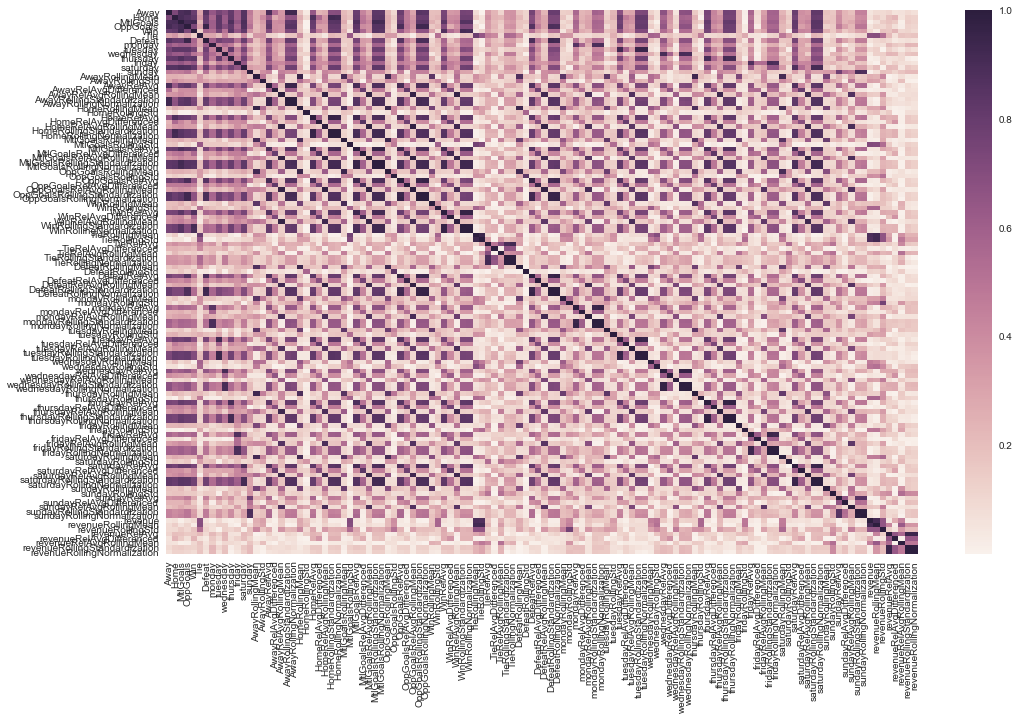

In [38]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(merged_df.corr().abs())


Let's zoom in on the part we're interested in. Correlation with revenue or any of its variants.

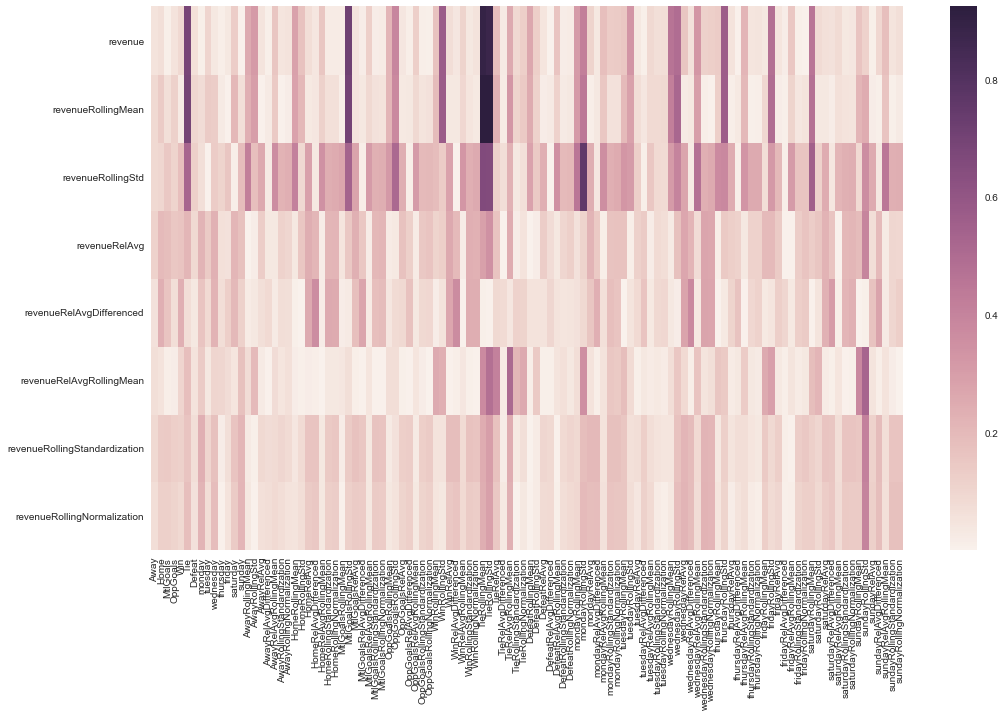

In [39]:
correlations_of_interest=merged_df.corr().abs().iloc[-8:,:-8]

sns.heatmap(correlations_of_interest)

Still too messy. Let's just look at the top candidates

In [40]:
min_corr=0.3

dict_of_df={}
for each_index in correlations_of_interest.index:
    cols_of_interest=correlations_of_interest.loc[each_index,:].values>min_corr
    if correlations_of_interest.loc[each_index,cols_of_interest].shape[0]>0:
        
        dict_of_df[each_index]=pd.DataFrame()
        dict_of_df[each_index]=correlations_of_interest.loc[each_index,cols_of_interest]

            

revenue
TieRollingMean          0.894079
TieRollingStd           0.875953
MtlGoalsRollingStd      0.713221
Tie                     0.687462
WinRollingStd           0.572935
thursdayRollingStd      0.568923
wednesdayRollingStd     0.496978
fridayRollingStd        0.483670
wednesdayRollingMean    0.462599
saturdayRollingMean     0.461135
Name: revenue, dtype: float64


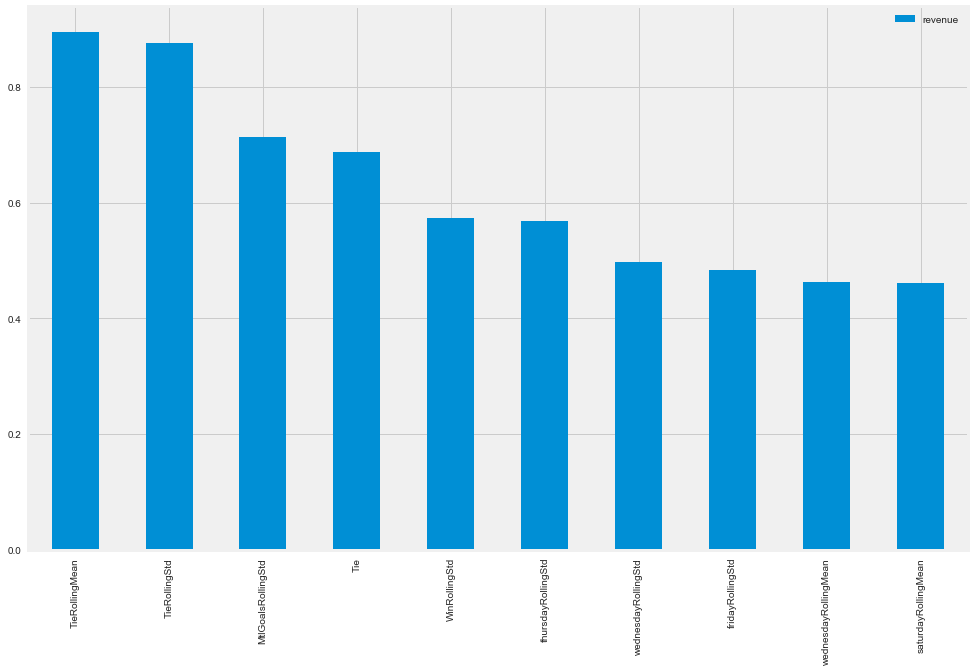

revenueRollingMean
TieRollingStd          0.923938
TieRollingMean         0.921120
MtlGoalsRollingStd     0.702919
Tie                    0.697860
WinRollingStd          0.572051
thursdayRollingStd     0.566853
wednesdayRollingStd    0.521184
fridayRollingStd       0.494088
saturdayRollingMean    0.474789
mondayRollingStd       0.444664
Name: revenueRollingMean, dtype: float64


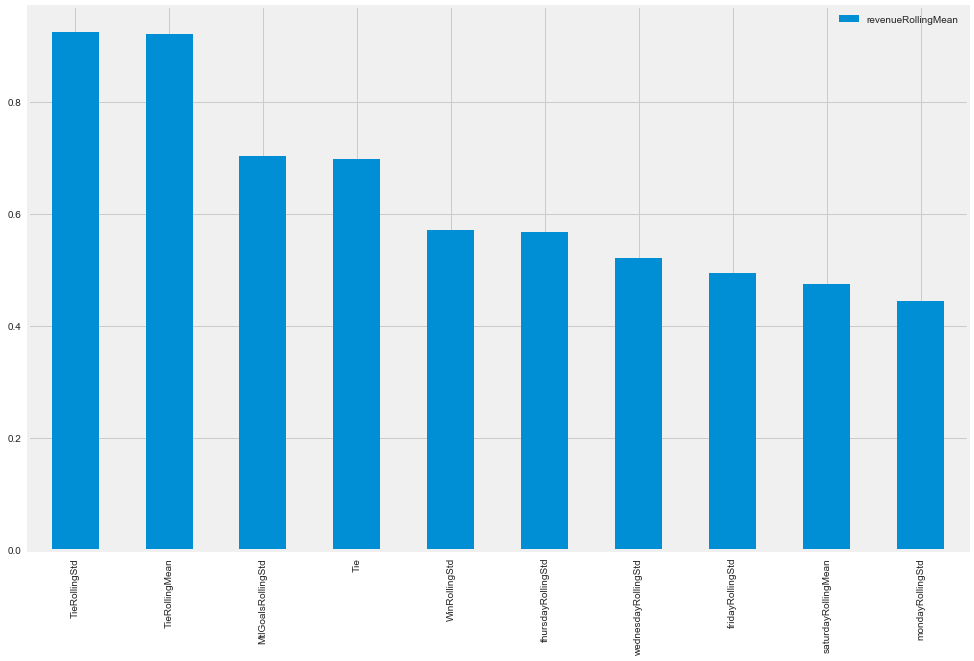

revenueRollingStd
mondayRollingStd              0.760877
TieRollingMean                0.662701
TieRollingStd                 0.660327
saturdayRollingMean           0.554064
MtlGoalsRollingStd            0.539508
Tie                           0.530441
OppGoalsRollingStd            0.512223
wednesdayRelAvgRollingMean    0.474632
mondayRollingMean             0.455241
sundayRelAvgRollingMean       0.449338
Name: revenueRollingStd, dtype: float64


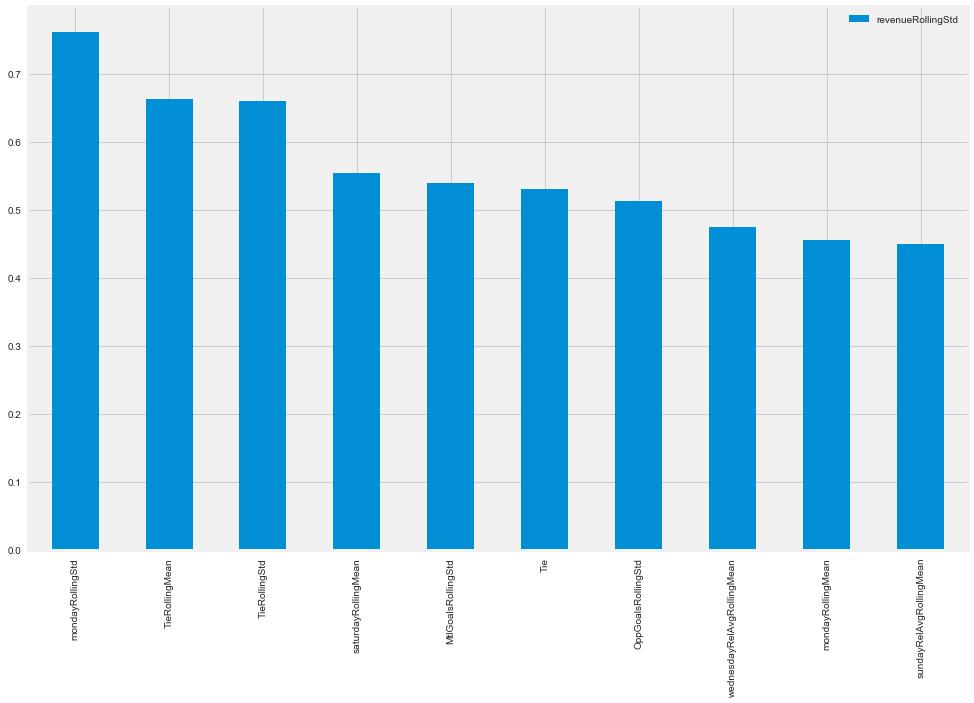

revenueRelAvg
sundayRollingStd    0.395335
TieRollingStd       0.350011
Name: revenueRelAvg, dtype: float64


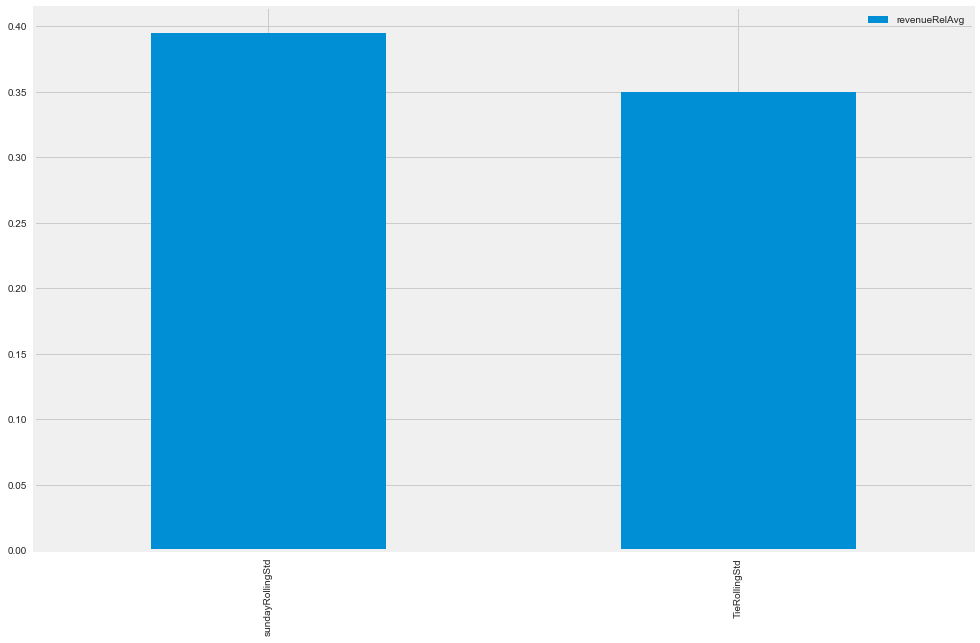

revenueRelAvgDifferenced
wednesdayRelAvgDifferenced    0.377179
WinRelAvgDifferenced          0.370065
HomeRelAvgDifferenced         0.362210
saturdayRelAvgDifferenced     0.304895
Name: revenueRelAvgDifferenced, dtype: float64


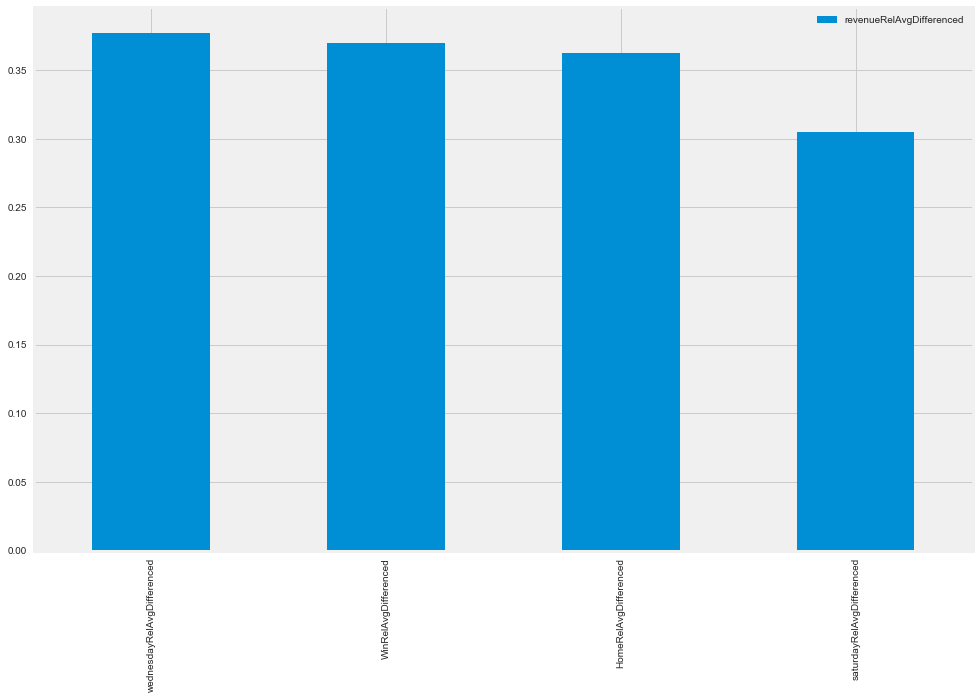

revenueRelAvgRollingMean
sundayRollingStd        0.527923
TieRelAvgRollingMean    0.516127
TieRollingStd           0.481755
TieRelAvg               0.411375
sundayRollingMean       0.380196
TieRollingMean          0.372519
mondayRollingStd        0.355549
Name: revenueRelAvgRollingMean, dtype: float64


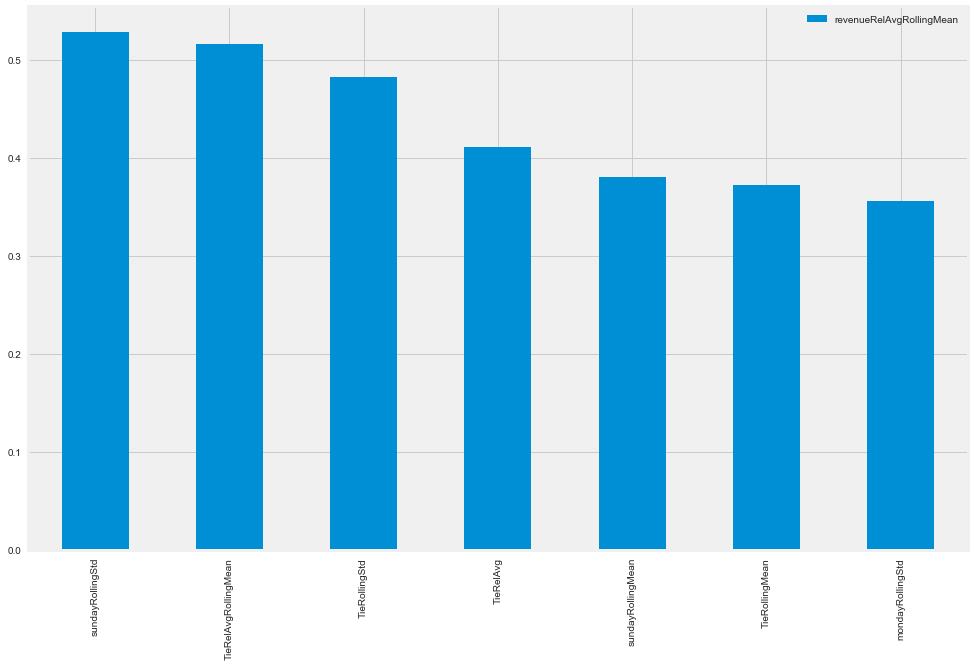

revenueRollingStandardization
sundayRollingStd    0.410594
TieRollingStd       0.300392
Name: revenueRollingStandardization, dtype: float64


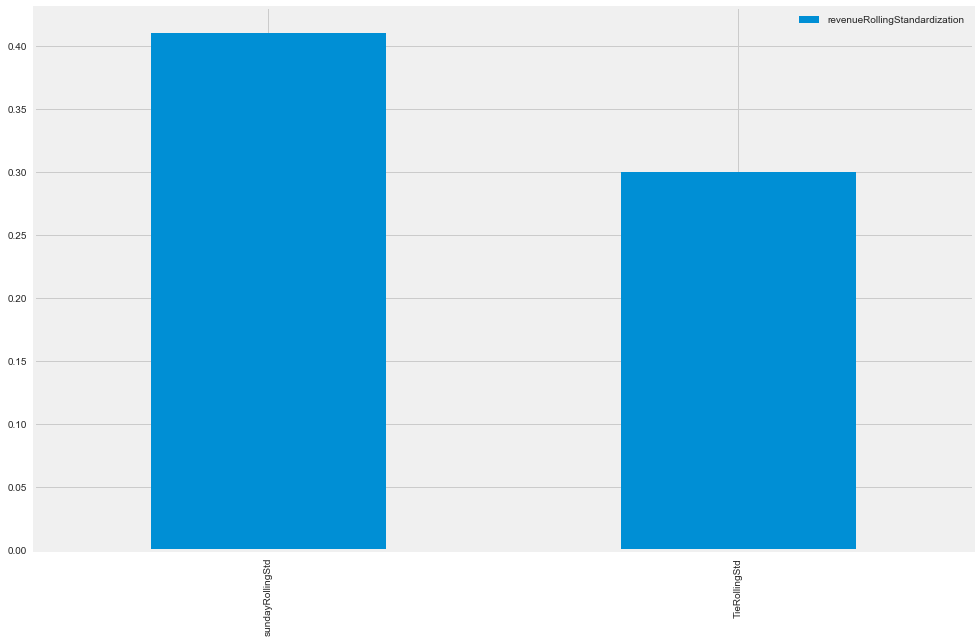

revenueRollingNormalization
sundayRollingStd    0.39931
Name: revenueRollingNormalization, dtype: float64


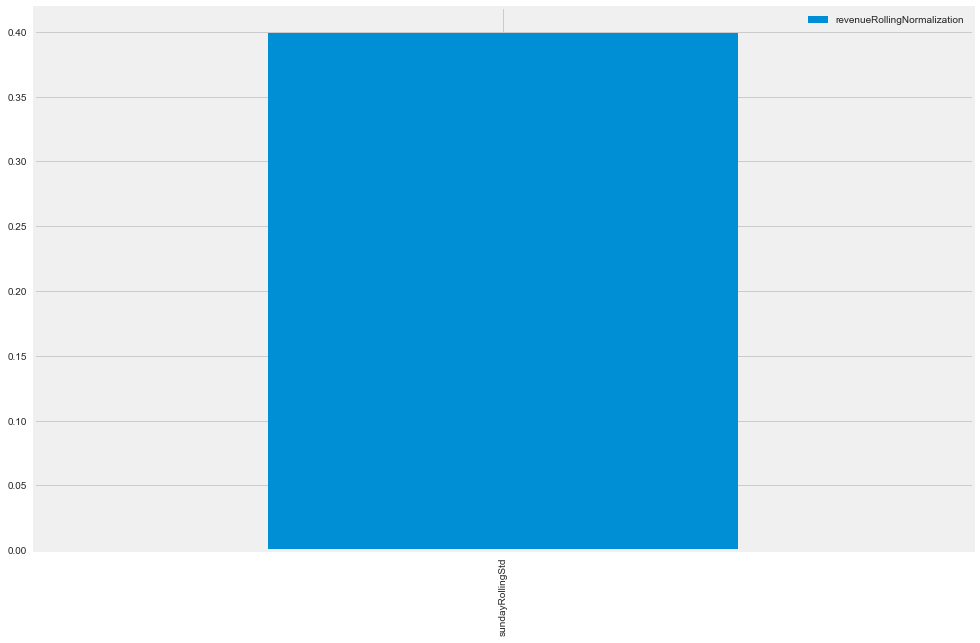

In [41]:
for each_key in dict_of_df.keys():
    print(each_key)
    print(dict_of_df[each_key].drop_duplicates().sort_values(ascending=False)[:10])
    dict_of_df[each_key].sort_values(ascending=False)[:10].plot(label=each_key,kind="bar")
    plt.legend()
    plt.show()

Here we can see the correlations of interest and some of it is surprising. Revenue correlating with the number of ties? Or the revenue Relative average rolling mean being correlated with the standard deviation of the number of games on saturdays? 

Clearly some of these correlations might be spurious. 

# TRYING SARIMAX AGAIN, WITH BOTH HOCKEY AND BAR PERFORMANCE

Now doing multiple regressions can be tricky. Given some variables it might detect only a few to be statistically significant, yet when you rerun the regression with only those pointed out as statistically significant, they statistical significance might disappear. Let me show what it looks like if we put all of hockey data in.

In [42]:
# Define the p, d and q paradmeters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


Like before you can set do_sarimax=True if you want to run the grid search, but it could take a while. By default I set it to the answer the gridsearch would have provided.

In [43]:

do_sarimax=False
x=smaller_hockey_df
if do_sarimax==True: #Sarimax can be time consuming. If I already know the answer, don't want this to run again.
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    best_score, best_cfg = float("inf"), None

    

    compare_matching_measure_only=False
    for each_measure_unit in ['revenueRelAvg','revenueRollingStandardization','revenueRelAvgRollingMean','revenueRollingNormalization']:
        print("Now checking out "+each_measure_unit)

        chosen_bar_data=smaller_business_data[each_measure_unit]
        #COMPARE ONLY WITH MATCHING MEASURE TYPE FOR X
        if compare_matching_measure_only==False:

            measure_units=['RelAvg','RollingStandardization','RollingNormalization','RelAvgRollingMean']
            chosen_measure_unit=[measure_unit for measure_unit in measure_units if measure_unit in each_measure_unit][0]

            print("chosen_measure_unit is "+chosen_measure_unit)
            cols_I_want=[col for col in x.columns if chosen_measure_unit in col]
            x_columns=x[cols_I_want]
        else:
            x_columns=x;

        for param in pdq:
            for param_seasonal in seasonal_pdq:

                try:
                    mod = sm.tsa.statespace.SARIMAX(chosen_bar_data,
                                                    order=param,
                                                    exog=x_columns,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()


                    if results.aic< best_score:
                        best_score=results.aic
                        best_cfg=[param, param_seasonal]
                        best_measure_unit=each_measure_unit.copy()
                        best_x_columns=x_columns
                        best_y_columns=chosen_bar_data

                        print('ARIMA{}x{} - AIC:{} with data {}'.format(param, param_seasonal, results.aic,each_measure_unit))
                except:
                    continue

    print("BEST FIT")            
    print('ARIMA{}x{} - AIC:{} with data {}'.format(best_cfg[0], best_cfg[1], best_score,best_measure_unit))
else:
    best_measure_unit="revenueRelAvg"
    
    cols_I_want=[col for col in x.columns if "RelAvg" in col]
    x_columns=x[cols_I_want]
    best_x_columns=x_columns
    best_y_columns=smaller_business_data[best_measure_unit]
    best_cfg=[(1, 1, 0), (0, 0, 0, 4)]

In [44]:
chosen_bar_data=best_y_columns


mod = sm.tsa.statespace.SARIMAX(chosen_bar_data,
                                order=best_cfg[0],#order=(1, 0, 1),
                                exog =best_x_columns, #putting in other regressors
                                seasonal_order=best_cfg[1],#seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())


                           Statespace Model Results                           
Dep. Variable:          revenueRelAvg   No. Observations:                   66
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  75.189
Date:                Wed, 05 Jul 2017   AIC                            -62.377
Time:                        16:33:48   BIC                             33.968
Sample:                    11-30-2000   HQIC                           -24.307
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
AwayRelAvg                    -0.0055      0.800     -0.007      0.995      -1.573       1.562
AwayRelAvgDifferenced         -0.5685      0.487     -1.167      0.243      -1.523 

c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Some analysis...

Having put in all hockey variables in one shot through the SARIMAX process, you'll notice that for a lot of them the P value is quite high. 

(While a low P value might mean your parameter is statisticically significant it doesn't necessarily mean the parameter is important. But still at the very least, the parameter needs to be statistically significant before we can wonder if it's useful or not. )

Still let's complete the rest of the analysis and see what it would have predicted.


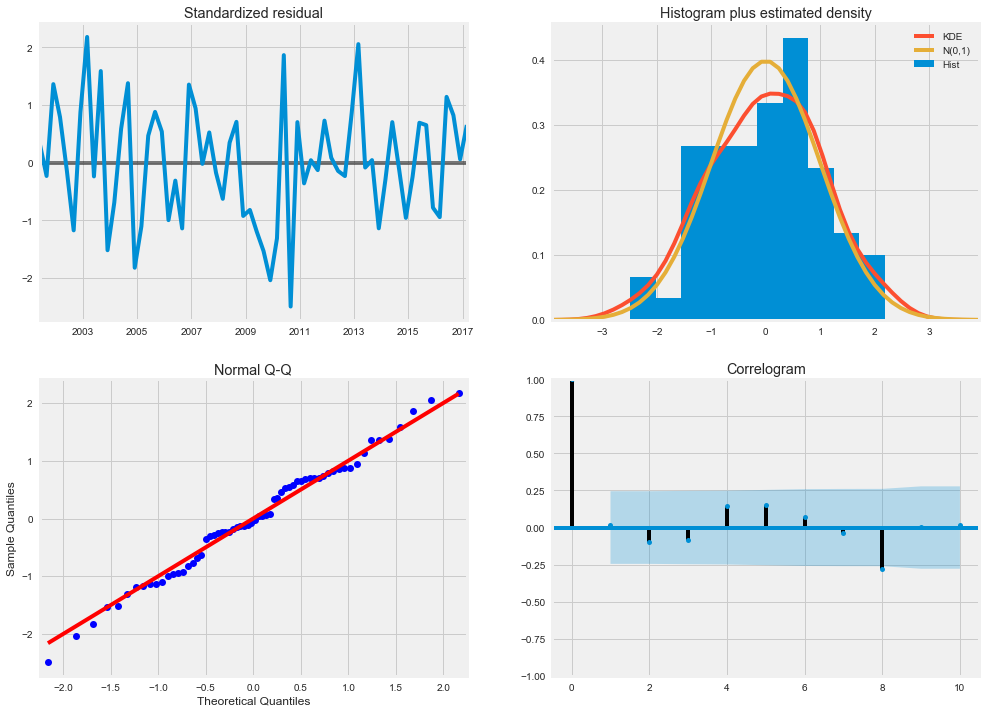

In [45]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

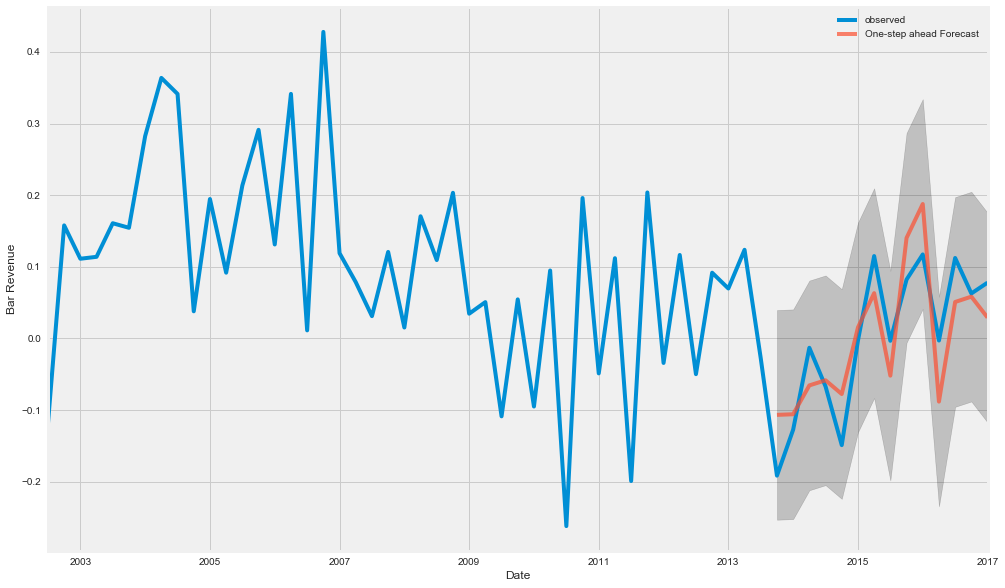

In [46]:
pred = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=False)
#The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.
pred_ci = pred.conf_int()

ax = chosen_bar_data[mid_data_index:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bar Revenue')
plt.legend()

plt.show()

In [47]:
y_forecasted = pred.predicted_mean #you'd add whatever other coefficients you want here. 
y_truth = chosen_bar_data[train_test_index:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse))





The Mean Squared Error of our forecasts is 0.003054036430520047


Again don't be fooled, just because the mean squared error went down from 0.01 to 0.004 doesn't mean it could really predict with greater accuracy on future data.

# Dynamic forecasting

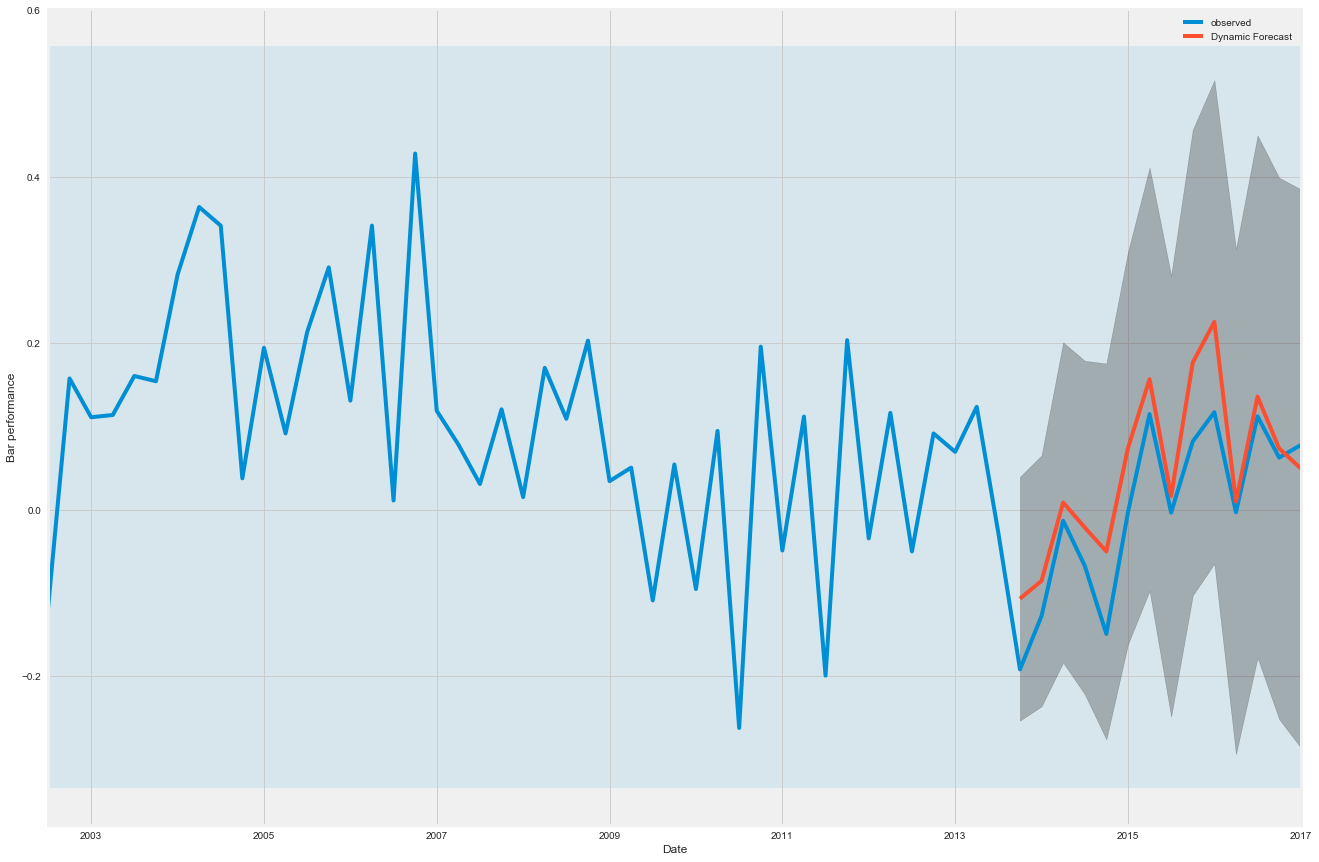

In [48]:
pred_dynamic = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = chosen_bar_data[mid_data_index:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(mid_data_index), bar_data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bar performance')

plt.legend()
plt.show()

# So where do we go from here? 
Simply taking out the high P values won't necessarily help because by taking out one variable, the p values of the other parameters change as well. 

I've decided to use a machine learning technique called ElasticNet Regression to shed some light on what variables (if any) help us in our predictions


# Elastic what?

Elastic regression is a combination of a ridge regression and a lasso regression.

# Ridge?

In a nutshell standard ordinary least squares (OLS) regressions don't typically do well with high dimensional problems.
This is because OLS gives the smallest mean squared error among linear estimators with NO BIAS.
Ridge regression tries to lower the error even more by adding more of a bias. 

# Lasso?

Lasso is an acronym for "Least Absolute Selection and Shrinkage Operator"
The only difference between lasso and ridge is that Lasso use what's called the L2 penalty and Ridge uses the L1 penalty. 
I can talk about the difference in a future post, but to be brief, the lasso can eliminate parameters that aren't statistically significant. Whereas the ridge regression simply keeps lowerering their coefficients but never turning them to 0. 


# And now the ElasticNet

It's a combination of ridge and the lasso. The reasoning is that when you're dealing with lots of variables, you'll often get a lot of them which are correlated with each other and form a sort of cluster if you will. Often times we will want these entire clusters of parameters to remain together should you choose any one of them. If you include one of the parameters you should include them all, if you delete one, you should delete them all. 

You can see it as the elimination properties of the lasso combined with the more lax "reduce but don't eliminate" method of the ridge regression. 




# Testing for stationarity...

Like before, before doing any analysis, let's make sure our series is stationary. 

Remember that the series we had the most success predicting on the Sarimax model was the revenue relative to its 2 year average (revenueRelAvg)

And so we will continue with that series and simply try to find the best hockey variables that could help us in our prediction. We will then try those variables on the Sarimax model once more.

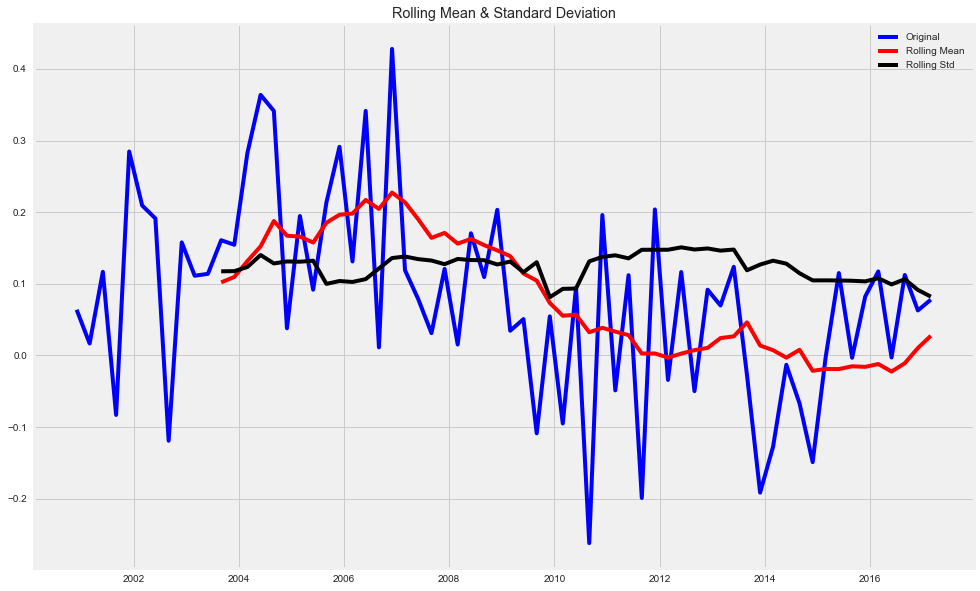

Results of Dickey-Fuller Test:
Test Statistic                -6.983509e+00
p-value                        8.078281e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


In [49]:

#chosen_bar_data=smaller_business_data["revenueRelAvg"]

differenced=False
logged=False

    
#if logged:
#    chosen_bar_data=np.log1p(chosen_bar_data)

    
if differenced:
    differenced_y=chosen_bar_data-chosen_bar_data.shift()
    differenced_y.dropna(inplace=True)

else:
    differenced_y=chosen_bar_data

    
if logged:
    chosen_bar_data=np.log1p(chosen_bar_data)

test_stationarity(differenced_y)


#elasticNet parameters
l1_ratio=0.5
alphas = np.arange(0.0, 3, 0.05)


Great! It's stationary, we didn't need to difference it nor log it. 

Now we'll try training our ElasticNet just using the hockey data, no lags just to see if anything pops up.

Here we split up the hockey data into its training and test sets.

In [50]:
from sklearn.linear_model import ElasticNetCV,ElasticNet #if you want lasso, just put l1_ratio=1 in ElasticNet Config
#Constant that multiplies the penalty terms alpha of 0 is more or less equiavlent to doing OLS

from sklearn.model_selection import cross_val_score

train_pct=0.8
test_pct=1-train_pct

x=smaller_hockey_df.loc[differenced_y.index]

data_dict=train_test(train_pct,x=x,y=differenced_y)
x_train=data_dict["x_train"]
x_test=data_dict["x_test"]
y_train=data_dict["y_train"]
y_test=data_dict["y_test"]
mid_data_index=data_dict["mid_data_index"]
all_y=differenced_y
all_x=x

The following function was taken from https://www.kaggle.com/apapiu/regularized-linear-models. It allows us to see how much regularization (which you configure in the alpha variable) is best for us. 

Regularization is basically a trade off between overfitting too much (where you infer too much from your training data) and over generalizing (the most extreme being just a straight line)

We set this through cross-validation which splits up your dataset into different train and test batches to see how well your model would have done had the training and testing sets been different. 

In our case, because we're dealing with a timeseries, we'll be using a special type of cross-validation that maintains the order in time of the train and test sets.

In [51]:
def rmse_cv(model,x_train, y_train,cv=5):
    #neg_mean_squared_error, neg_mean_absolute_error
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
	#with scoring being blank, by default this would've outputted the accuracy, ex: 95%
	#with scoring="neg_mean_squared_error", we get accuracy -1, so shows by how much you were off and it's negative
	#then with the - in front, gives you the error, but positive. 
    return(rmse)

c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpec

alpha chosen at 0.450000


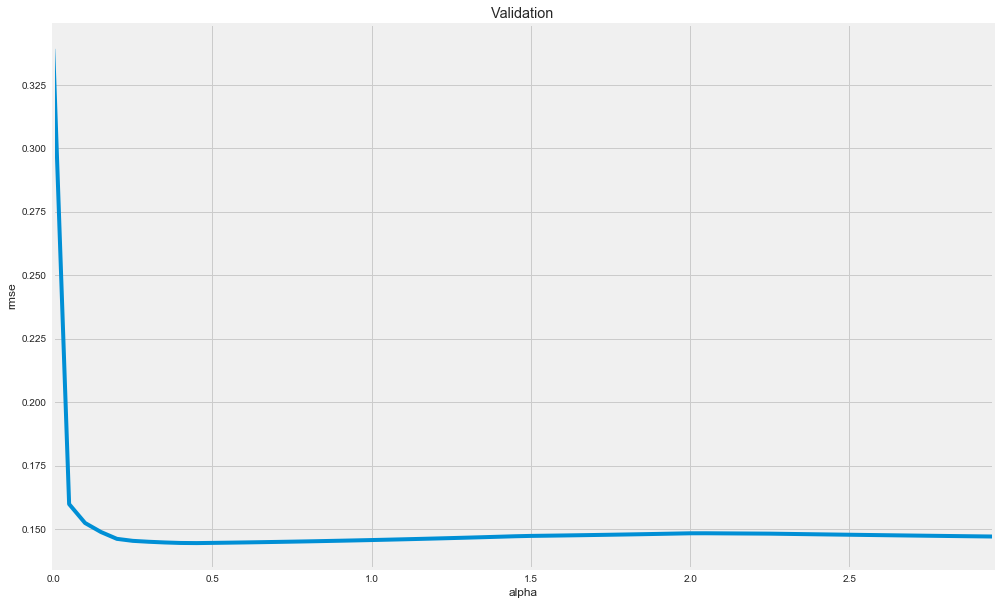

In [52]:

from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

cv_elastic = [rmse_cv(ElasticNet(normalize =False,alpha = alpha,l1_ratio=l1_ratio,max_iter=1000),x_train, y_train,cv=cv).mean() for alpha in alphas]

cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

chosen_alpha=cv_elastic.idxmin() #where the error is lowest

print("alpha chosen at %f" %chosen_alpha)

model_elastic=ElasticNet(normalize =False,alpha = chosen_alpha,l1_ratio=l1_ratio,max_iter=1000).fit(x_train, y_train)


Lasso picked 1 variables and eliminated the other 111 variables
score of 0.083588


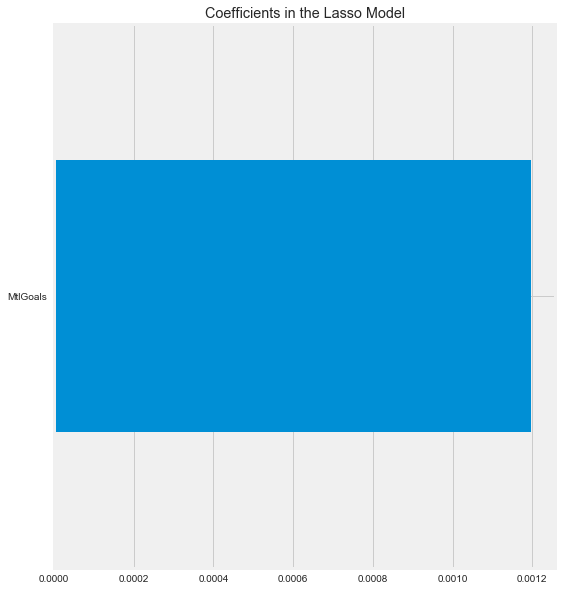

In [53]:
import matplotlib
#FEATURE SELECTION
#getting an idea of what's important and what isn't.  

features=x_train.columns
coef = pd.Series(model_elastic.coef_, index = features)
nber_of_variables=sum(coef != 0)

print("Lasso picked " + str(nber_of_variables) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

print("score of %f"%model_elastic.score(x_train,y_train))

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef.abs().sort_values()[-nber_of_variables:].plot(kind = "barh")

plt.title("Coefficients in the Lasso Model")

#let's say we keep 


Well, it looks like the elastic net picked up only variable that was statistically significant on its own. But even at that, it seems very weak, just look at that coefficient...

# Plotting the differenced data

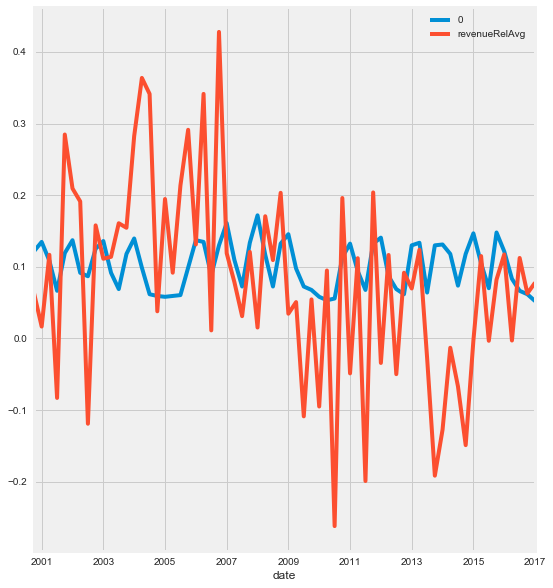

In [54]:

pred=pd.DataFrame(model_elastic.predict(x),index=x.index)

answer=pd.concat([pred,differenced_y],axis=1)

answer.plot()


In [55]:
#This is to put it back into its original measurement.
def undo_differencing(original_y,prediction):
    original_y=pd.DataFrame(original_y)
    prediction=pd.DataFrame(prediction)
    answer = pd.Series(original_y.iloc[0].values, index=original_y.index)   

    combined=pd.concat([answer,prediction.cumsum()],axis=1).fillna(0)

    combined=combined.sum(axis=1)
    return combined




In case I had differend the series or logged it, I would undo them here, so as to see what our final prediction would have been. Also here we would've had a step forward prediciton, whereby we'd be using the a real observation at each step to help predict the next one.

My forecast MSE : 0.018654634970422072, 
simply using previous value MSE : 0.033328210182247665, 
straight line MSE :0.025236199218369736


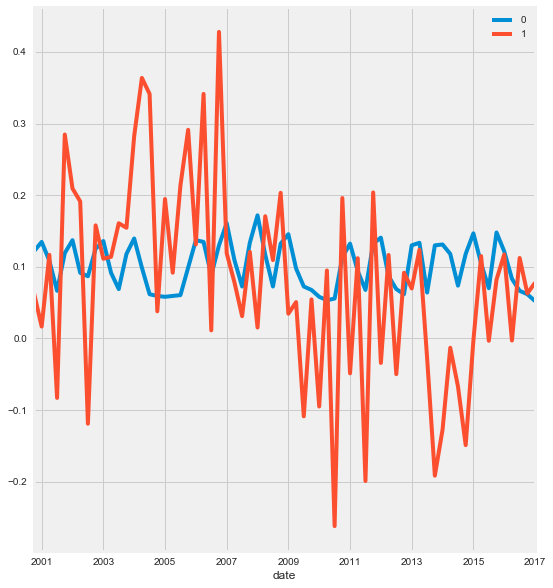

In [56]:
#STEP FORWARD PREDICTION

prediction=model_elastic.predict(x)
prediction=pd.Series(prediction,index=x.index)


if logged:
    prediction=np.exp(prediction)-1

if differenced:
    final_pred=(prediction+chosen_bar_data.shift()).dropna()

else:    
    #WITHOUT DIFFERENCING
    final_pred=pd.Series(prediction,index=x.index)
    #final_pred=np.exp(final_pred)

    
answer=pd.concat([final_pred,chosen_bar_data],axis=1,ignore_index=True)

#answer

forecast_mse = ((final_pred - chosen_bar_data) ** 2).mean()
baseline_mse = ((chosen_bar_data-chosen_bar_data.shift()) ** 2).mean()
no_guess_mse=((chosen_bar_data) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))


answer.plot()


As you can see, based on the montreal goals, it's only willing to predict so much one way or another. Still it is interesting to note that it's performing better than simply a straight line through 0 as well as simply predicting the previous value, so something's going on!

My forecast MSE : 0.018654634970422072, 
simply using previous value MSE : 0.033328210182247665, 
straight line MSE :0.025236199218369736


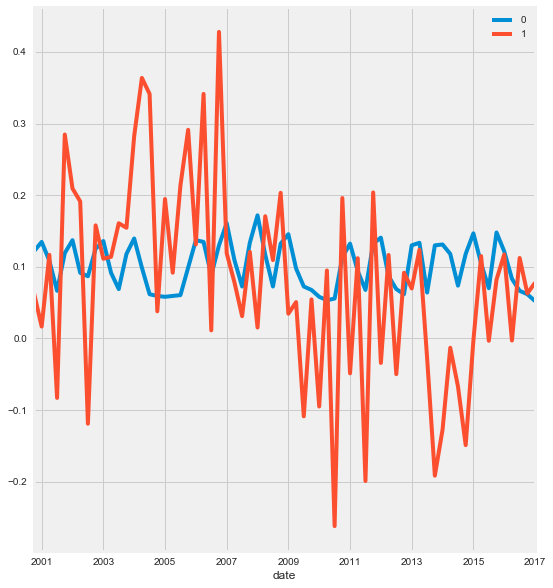

In [57]:
#DYNAMIC PREDICTION
if logged:
    prediction=np.exp(prediction)-1

    
if differenced:
    final_pred=undo_differencing(chosen_bar_data,pd.Series(prediction,index=x.index))

else:    
    #WITHOUT DIFFERENCING
    final_pred=pd.Series(prediction,index=x.index)
    #final_pred=np.exp(final_pred)

answer=pd.concat([final_pred,chosen_bar_data],axis=1,ignore_index=True)

#answer

forecast_mse = ((final_pred - chosen_bar_data) ** 2).mean()

baseline_mse = ((chosen_bar_data-chosen_bar_data.shift()) ** 2).mean()

no_guess_mse=((chosen_bar_data) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))

answer.plot()


If we were dealing with differenced data, above we'd have the dynamic prediction whereby we predict the next value based on our previously predicted values for the current period.

# ElasticNet With Lags

Out of curiosity let's just see what the ElasticNet thinks of using past values to help with the prediction.

In [58]:

#list_of_lags=list(range(1,5)
def make_lags(list_of_lags,y_serie):
    data=pd.DataFrame()
    for each in list_of_lags:
        lag=y_serie.shift(each)
        lag=lag.rename("lag %i"%each)
        data=pd.concat([data,lag],axis=1)
    data.dropna(inplace=True)
    return data

y_train_lags=make_lags(list(range(1,5)),y_train)
y_test_lags=make_lags(list(range(1,5)),y_test)
all_y_lags=make_lags(list(range(1,5)),all_y)

x_train_with_lags=pd.concat([x_train,y_train_lags],axis=1)
x_train_with_lags.dropna(inplace=True)
x_test_with_lags=pd.concat([x_test,y_test_lags],axis=1)
x_test_with_lags.dropna(inplace=True)
all_x_with_lags=pd.concat([x_train,y_train_lags],axis=1)
all_x_with_lags.dropna(inplace=True)

In [59]:
#because of the lags, you can't compare with all of y_train, the lags will lower the number of data points for your input
dates_in_common_train=np.intersect1d(x_train_with_lags.index.values, y_train.index.values)
y_train_lagged=y_train.loc[dates_in_common_train]

dates_in_common_test=np.intersect1d(x_test_with_lags.index.values, y_test.index.values)
y_test_lagged=y_test.loc[dates_in_common_test]

dates_in_common_all=np.intersect1d(all_x_with_lags.index.values, all_y.index.values)
all_y_lagged=all_y.loc[dates_in_common_all]

chosen_bar_data_lagged=chosen_bar_data.loc[dates_in_common_all]



c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpec

alpha chosen at 0.450000


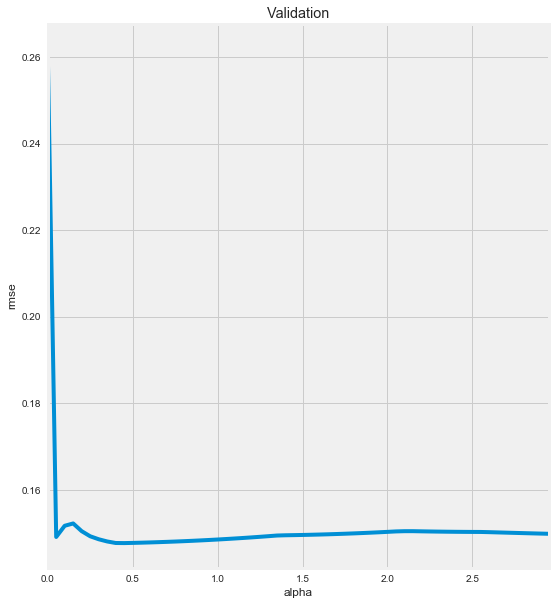

In [60]:

cv_elastic = [rmse_cv(ElasticNet(normalize =False,alpha = alpha,l1_ratio=l1_ratio,max_iter=1000),x_train_with_lags, y_train_lagged,cv=cv).mean() for alpha in alphas]

cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

chosen_alpha=cv_elastic.idxmin() #where the error is lowest

print("alpha chosen at %f" %chosen_alpha)


model_elastic=ElasticNet(normalize =False,alpha = chosen_alpha,l1_ratio=l1_ratio,max_iter=1000).fit(x_train_with_lags, y_train_lagged)





Lasso picked 1 variables and eliminated the other 115 variables
score of 0.085072


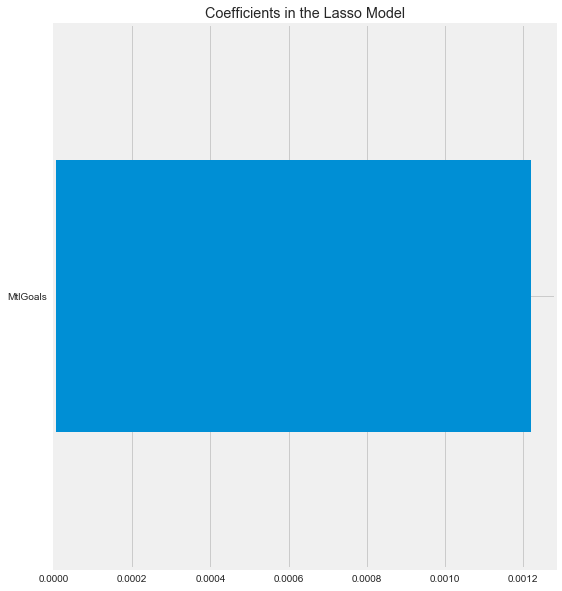

In [61]:
#FEATURE SELECTION
#getting an idea of what's important and what isn't.  
features=x_train_with_lags.columns
coef = pd.Series(model_elastic.coef_, index = features)
nber_of_variables=sum(coef != 0)

print("Lasso picked " + str(nber_of_variables) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

print("score of %f"%model_elastic.score(x_train_with_lags,y_train_lagged))

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef.abs().sort_values()[-nber_of_variables:].plot(kind = "barh")


if nber_of_variables==0:
    winning_coef=[""]
else:
    winning_coef=coef.abs().sort_values()[-nber_of_variables:].index.values
    winning_coef=winning_coef[::-1]


plt.title("Coefficients in the Lasso Model")

#let's say we keep 


Like the Sarimax model found out, the normal lags weren't found to be useful.

My forecast MSE : 0.018082864802022217, 
simply using previous value MSE : 0.039087678125240256, 
straight line MSE :0.031344728819424336


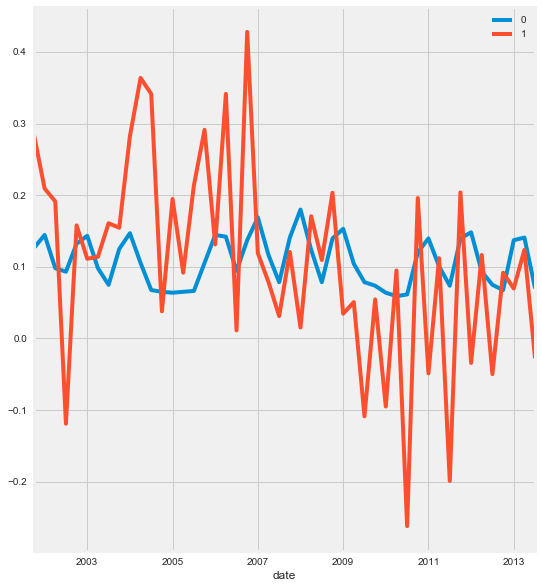

In [62]:
#STEP FORWARD PREDICTION

prediction=model_elastic.predict(all_x_with_lags)
prediction=pd.Series(prediction,index=all_x_with_lags.index)

if logged:
    prediction=np.exp(prediction)-1

if differenced:
    final_pred=(prediction+chosen_bar_data_lagged.shift()).dropna()

else:    
    #WITHOUT DIFFERENCING
    final_pred=pd.Series(prediction,index=all_x_with_lags.index)
    #final_pred=np.exp(final_pred)

    
answer=pd.concat([final_pred,chosen_bar_data_lagged],axis=1,ignore_index=True)


#answer

forecast_mse = ((final_pred - chosen_bar_data_lagged) ** 2).mean()
baseline_mse = ((all_y_lagged-chosen_bar_data_lagged.shift()) ** 2).mean()
no_guess_mse=((chosen_bar_data_lagged) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))


answer.plot()



My forecast MSE : 0.018082864802022217, 
simply using previous value MSE : 0.039087678125240256, 
straight line MSE :0.031344728819424336


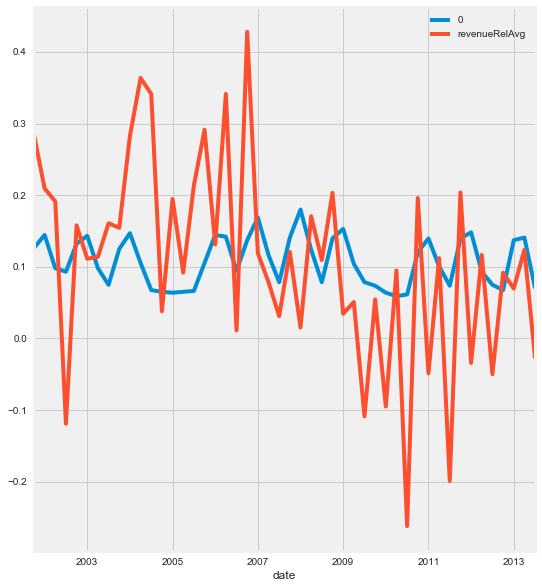

In [63]:
#DYNAMIC PREDICTION

prediction=model_elastic.predict(all_x_with_lags)
prediction=pd.Series(prediction,index=all_x_with_lags.index)

if logged:
    prediction=np.exp(prediction)-1

    
if differenced:
    final_pred=undo_differencing(chosen_bar_data_lagged,pd.Series(prediction,index=all_x_with_lags.index))

else:    
    #WITHOUT DIFFERENCING
    final_pred=pd.Series(prediction,index=all_x_with_lags.index)
    #final_pred=np.exp(final_pred)

    

answer=pd.concat([final_pred,chosen_bar_data_lagged],axis=1).dropna()

#answer
forecast_mse = ((final_pred - chosen_bar_data_lagged) ** 2).mean()
baseline_mse = ((chosen_bar_data_lagged-chosen_bar_data_lagged.shift()) ** 2).mean()
no_guess_mse=((chosen_bar_data_lagged) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))

answer.plot()



# Back to Sarimax

So we've got MtlGoals as the only significant variable, which kind of makes sense. Let's put that in our model and see if it improves things. 

In [64]:
# Define the p, d and q paradmeters to take any value between 0 and 2
p =  q = range(0, 4)
d =range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))


# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 2)
SARIMAX: (0, 0, 1) x (0, 0, 2, 2)
SARIMAX: (0, 0, 2) x (0, 0, 3, 2)
SARIMAX: (0, 0, 2) x (0, 1, 0, 2)


Like before you can run the gridsearch if you want, but the answer has been saved in the next cell. It's 

BEST FIT
ARIMA(0, 0, 0)x(1, 0, 0, 2) - AIC:-74.1056787276343
parameters in play
['MtlGoals']

In [65]:
do_sarimax=False
if do_sarimax==True:    
    #cols_I_want=winning_coef
    cols_I_want=["MtlGoals"]  
    cols_in_play=[]
    best_score, best_cfg = float("inf"), None
    for each_col in cols_I_want:
        cols_in_play.append(each_col)
        print(each_col)
        x_columns=x_train[cols_in_play]

        warnings.filterwarnings("ignore") # specify to ignore warning messages

        for param in pdq:
            for param_seasonal in seasonal_pdq:

                try:
                    mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,#order=(1, 0, 1),
                                            exog =x_columns, #putting in other regressors
                                            seasonal_order=param_seasonal,#seasonal_order=(1, 0, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                    results = mod.fit()


                    if results.aic< best_score:
                        best_score=results.aic
                        best_cfg=[param, param_seasonal]

                        parameters_in_play=cols_in_play.copy()
                        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                        #print("best parameters so far")
                        #print(parameters_in_play)
                except:
                    continue

    print("BEST FIT")            
    print('ARIMA{}x{} - AIC:{}'.format(best_cfg[0], best_cfg[1], best_score))
    print("parameters in play")
    print(parameters_in_play)


MtlGoals
ARIMA(0, 0, 0)x(0, 0, 1, 2) - AIC:-62.29608042382739
ARIMA(0, 0, 0)x(0, 0, 2, 2) - AIC:-65.54941555285707
ARIMA(0, 0, 0)x(0, 1, 1, 2) - AIC:-67.53613009678573
ARIMA(0, 0, 0)x(1, 0, 0, 2) - AIC:-74.1056787276343
BEST FIT
ARIMA(0, 0, 0)x(1, 0, 0, 2) - AIC:-74.1056787276343
parameters in play
['MtlGoals']


                            Statespace Model Results                           
Dep. Variable:           revenueRelAvg   No. Observations:                   66
Model:             SARIMAX(1, 0, 0, 2)   Log Likelihood                  48.535
Date:                 Wed, 05 Jul 2017   AIC                            -91.071
Time:                         16:39:51   BIC                            -84.502
Sample:                     11-30-2000   HQIC                           -88.475
                          - 02-28-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MtlGoals       0.0014      0.000      3.399      0.001       0.001       0.002
ar.S.L2        0.5630      0.099      5.663      0.000       0.368       0.758
sigma2         0.0129      0.002      5.612 

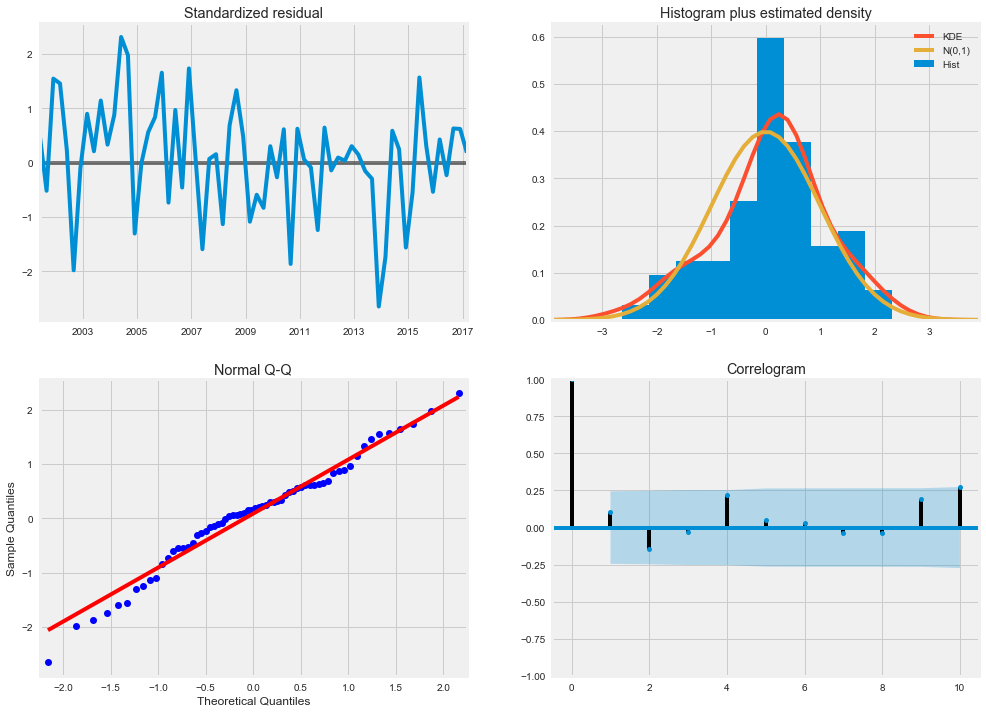

PREDICTION NOT DYNAMIC


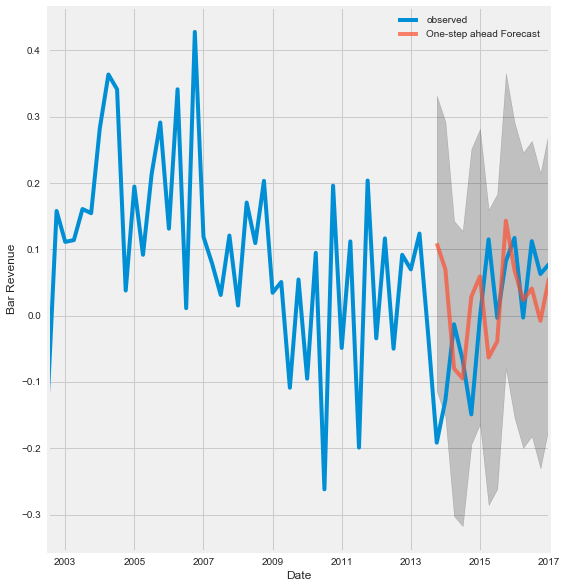

TEST ERRORS ANALYSIS
My forecast MSE : 0.008557910103226384, 
simply using previous value MSE : 0.009794591037589584, 
straight line MSE :0.007860207463530363
PREDICTION DYNAMIC


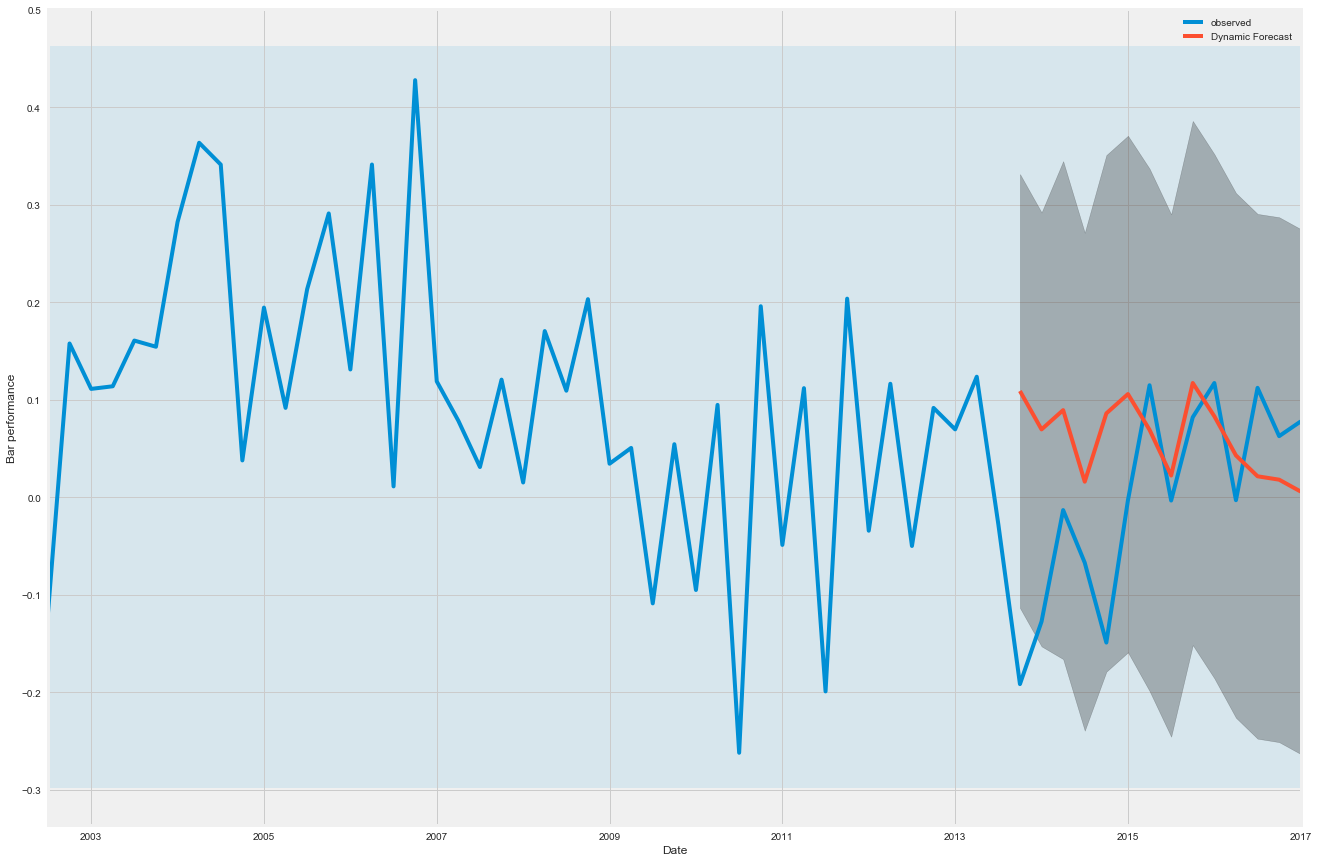

TEST ERRORS ANALYSIS
My forecast MSE : 0.008978980313352402, 
simply using previous value MSE : 0.009794591037589584, 
straight line MSE :0.007860207463530363


In [66]:
cols_in_play=[]

cols_I_want=["MtlGoals"] #wednesdayRelAvgDifferenced
#cols_I_want=parameters_in_play 
x_columns=all_x[cols_I_want] #TieRollingStd


best_cfg=[(0, 0, 0),(1, 0, 0, 2)] #with MtlGoals

#with no hockey,
#best_cfg=[(0, 0, 0)x(1, 0, 1, 2)]   


mod = sm.tsa.statespace.SARIMAX(all_y,
                                order=best_cfg[0],#order=(1, 0, 1),
                                exog =x_columns, #putting in other regressors
                                #exog=None,
                                seasonal_order=best_cfg[1],#seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

results.plot_diagnostics(figsize=(15, 12))
plt.show()



In [ ]:
print("PREDICTION NOT DYNAMIC")
pred = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=False)
#The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.
pred_ci = pred.conf_int()

ax = all_y[mid_data_index:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bar Revenue')
plt.legend()
plt.show()

print("TEST ERRORS ANALYSIS")



y_forecasted = pred.predicted_mean #you'd add whatever other coefficients you want here. 
y_truth=y_test_lagged


forecast_mse = ((y_forecasted - y_truth) ** 2).mean()

baseline_mse = ((y_truth-y_truth.shift()) ** 2).mean()

no_guess_mse=((y_truth) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))





In [ ]:
print("PREDICTION DYNAMIC")
pred_dynamic = results.get_prediction(start=pd.to_datetime(y_test.index[0]), dynamic=True, full_results=True)

pred_dynamic_ci = pred_dynamic.conf_int()

ax = all_y[mid_data_index:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(mid_data_index), bar_data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bar performance')

plt.legend()
plt.show()

print("TEST ERRORS ANALYSIS")

y_forecasted = pred_dynamic.predicted_mean
#y_truth = other_y_test #from the test going forward only

forecast_mse = ((y_forecasted - y_truth) ** 2).mean()
baseline_mse = ((y_truth-y_truth.shift()) ** 2).mean()
no_guess_mse=((y_truth) ** 2).mean()

print("My forecast MSE : {}, \nsimply using previous value MSE : {}, \nstraight line MSE :{}".format(forecast_mse,baseline_mse,no_guess_mse))


Above you'll se both the regulard and dynamic regressions. It looks like the best model including the MtlGoals variable outperforms our previous model that didn't have any hockey data at all. 

And also look at those P values, they are all below 0.05. And finally the AIC score is lower with a value of -91

But after all this, it must noted as well that it didn't beat simpling predicting the value of 0 for this test case. Predicing 0 means that the best guess for the next quarterly revenue is the current quarterly revenue average.

But still if you look at the training data, a lot of the time the values were much higher than 0. It just happens 

# Here are the final results

Mean squared error (Not Dynamic)

With MtlGoals: 0.00855 --- Without MtlGoals 0.0129

Mean squared error (Dynamic) 

With MtlGoals: 0.00897 --- Without MtlGoals 0.0144

AIC score:

With MTL Goals: -91 -- Without MtlGoals -64


And there you have it, when predicting the quarterly revenue of Sportscene relative to its 2 year average, it seems the number of goals scored by the Montreal Canadiens team does help in predicting the next quarterly revenue at least a little bit.

This also means that MOST of the sports bar business' success is NOT explained by the performance of the Montreal Canadiens. They could always lose and it wouldn't affect them that much. 

This either means:

Loyal fans will show up no matter what.

A large portion of the sports' bars clientel who show up there for something else than hockey. It could be for other sports, or maybe the lively atmosphere.

# Other things to explore

There was tremendous growth earlier on in the timeseries. Compared with the flattish quarterly revenue (2009 and onward), this could be seen as a "paradigm" shift. We could try running the training only on 2009 onwards to see what it would give.

We could try automatically detecting a change in behaviour like this with Monte Carlo Markov Chains.

And finally seeing as there are only 4 periods in a year, why could just try turning them into dummy variables and running the analysis as as normal series (with independent datapoints) instead of a timeseries.